In [1]:
import torch
import torch.nn as nn
import math
import numpy as np
import random
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
#import spacy
from torchtext.legacy.data import Field, BucketIterator
from sklearn.model_selection import train_test_split
from torchtext.vocab import build_vocab_from_iterator
import re
from transformers import BertTokenizer
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
from dataloader import *
from transformer import *

# Model definition

In [3]:
class TransformerClassifier(torch.nn.Module):

    def __init__(self, src_pad_idx, enc_voc_size, max_len, d_model, ffn_hidden, n_head, n_layers, drop_prob, device):
        super(TransformerClassifier, self).__init__()

        self.src_pad_idx = src_pad_idx
        self.encoder = Encoder(enc_voc_size, max_len, d_model, ffn_hidden, n_head, n_layers, drop_prob, device)
        self.linear = nn.Linear(d_model * max_len, 2).to(device)

    def make_pad_mask(self, q, k):
        len_q, len_k = q.size(1), k.size(1)

        # batch_size x 1 x 1 x len_k
        k = k.ne(self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # batch_size x 1 x len_q x len_k
        k = k.repeat(1, 1, len_q, 1)

        # batch_size x 1 x len_q x 1
        q = q.ne(self.src_pad_idx).unsqueeze(1).unsqueeze(3)
        # batch_size x 1 x len_q x len_k
        q = q.repeat(1, 1, 1, len_k)

        mask = k & q
        return mask

    def forward(self, x):
        mask = self.make_pad_mask(x, x)
        x = self.encoder(x, mask)
        x = x.view(x.shape[0], -1)
        x = self.linear(x)
        return x

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.kaiming_uniform(m.weight.data)

In [5]:
def plot_training(history, marker=None):
  plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.5,
                    top=0.6,
                    wspace=0.4,
                    hspace=0.4)

  plt.subplot(1, 2, 1)
  plt.plot(history['train_loss'])
  plt.plot(history['val_loss'])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.title('Training loss')

  # vertical line for marking best epoch
  if marker is not None:
    y_min = min(history['train_loss'] + history['val_loss'])
    y_max = max(history['train_loss'] + history['val_loss'])
    plt.vlines(x=marker, ymin=y_min, ymax=y_max, color='red')

  plt.subplot(1, 2, 2)
  plt.plot(history['train_acc'])
  plt.plot(history['val_acc'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.title('Training metric')

  # vertical line for marking best epoch
  if marker is not None:
    y_min = min(history['train_acc'] + history['val_acc'])
    y_max = max(history['train_acc'] + history['val_acc'])
    plt.vlines(x=marker, ymin=y_min, ymax=y_max, color='red')

  plt.show()

In [6]:
def validation(model, iterator, optimizer, criterion, device):
    # set model into evaluation mode
    model.eval()

    # validation
    # loss, metrics for current epoch
    val_epoch_loss = 0
    val_epoch_accuracy = 0

    with torch.no_grad(): # stop graph
        # batches
        for i, batch in enumerate(iterator):
            src = batch[0] # X
            trg = batch[1] # y
            src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
            output = model(src)
            y_pred = torch.argmax(output, dim=-1) # logits -> labels
            output_reshape = output.contiguous().view(-1, output.shape[-1])
            trg = trg.to(torch.int64)

            loss = criterion(output_reshape, trg) # calculate loss
            agreements = torch.eq(y_pred, trg)
            accuracy = torch.mean(agreements.double()) # calculate accuracy

            val_epoch_loss += loss.item()
            val_epoch_accuracy += accuracy

    # return mean loss w.r.t. batches
    return val_epoch_loss / len(iterator), val_epoch_accuracy / len(iterator)

def train(model, iterator, optimizer, criterion, epoch, clip, device):
    # set model into training mode
    model.train()

    scheduler = ReduceLROnPlateau(optimizer, 'min')

    # save data - init
    history = {'train_loss': [],
               'val_loss': [],
               'train_acc': [],
               'val_acc': []}

    # training
    for e in range(epoch):
        # loss, metrics for current epoch
        epoch_loss = 0
        epoch_acc = 0

        # batches
        for i, batch in enumerate(tqdm(iterator)):
            src = batch[0] # X
            trg = batch[1] # y
            src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
            optimizer.zero_grad() # reset optimizer
            output = model(src) # predict
            y_pred = torch.argmax(output, dim=-1) # logits -> labels
            output_reshape = output.contiguous().view(-1, output.shape[-1])
            trg = trg.to(torch.int64)
            loss = criterion(output_reshape, trg) # calculate loss
            agreements = torch.eq(y_pred, trg)
            accuracy = torch.mean(agreements.double()) # calculate accuracy
            loss.backward() # backward pass

            epoch_loss += loss.item()
            epoch_acc += accuracy / len(iterator)

            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step() # optimize model

        # validation
        val_loss, val_acc = validation(model, valid_iter, optimizer, criterion, device)

        # save data
        with torch.no_grad():
          for key, value in zip(history.keys(), [epoch_loss / len(iterator), val_loss, epoch_acc, val_acc]):
            history[key].append(value)

        # visualization
        print(f"Epoch: {e + 1}  Train Loss: {epoch_loss / len(iterator):.4f} \
              Validation Loss: {val_loss:.4f} \
              Train acc: {epoch_acc:.4f}, \
              Val acc: {val_acc:.4f}")

    # print training curve
    plot_training(history)

    return history

def train_save_best(model, iterator, optimizer, criterion, epoch, clip, device):
    # set model into training mode
    model.train()

    scheduler = ReduceLROnPlateau(optimizer, 'min')

    # save data - init
    history = {'train_loss': [],
               'val_loss': [],
               'train_acc': [],
               'val_acc': [],
               'learning_rate': []}
    best_model = None
    best_model_score = 1e9
    best_model_epoch = 0

    # training
    for e in range(epoch):
        # loss, metrics for current epoch
        epoch_loss = 0
        epoch_acc = 0

        # batches
        for i, batch in enumerate(tqdm(iterator)):
            src = batch[0] # X
            trg = batch[1] # y
            src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
            optimizer.zero_grad() # reset optimizer
            output = model(src) # predict
            y_pred = torch.argmax(output, dim=-1) # logits -> labels
            output_reshape = output.contiguous().view(-1, output.shape[-1])
            trg = trg.to(torch.int64)
            loss = criterion(output_reshape, trg) # calculate loss
            agreements = torch.eq(y_pred, trg)
            accuracy = torch.mean(agreements.double()) # calculate accuracy
            loss.backward() # backward pass

            epoch_loss += loss.item()
            epoch_acc += accuracy / len(iterator)

            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step() # optimize model

        # validation
        val_loss, val_acc = validation(model, valid_iter, optimizer, criterion, device)
        
        scheduler.step(val_loss)

        # save data
        with torch.no_grad():
            current_lr = optimizer.param_groups[0]['lr']

            for key, value in zip(history.keys(), [epoch_loss / len(iterator), val_loss, epoch_acc, val_acc, current_lr]):
                history[key].append(value)

            # save best model (w.r.t validation loss)
            if val_loss < best_model_score:
                best_model = model.state_dict()
                best_model_score = val_loss
                best_model_epoch = e

        # visualization
        print(f"Epoch: {e + 1}  Train Loss: {epoch_loss / len(iterator):.4f} \
              Validation Loss: {val_loss:.4f} \
              Train acc: {epoch_acc:.4f}, \
              Val acc: {val_acc:.4f}")

    # print training curve
    plot_training(history, marker=best_model_epoch)

    return history, best_model, best_model_score

# Import data

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [8]:
# init
tokenizer = Tokenizer()
loader = DataLoader(tokenize = tokenizer.tokenize)

# import data (combine train/test as we split afterwards anyways)
data = pd.concat([pd.read_csv("./Data/SMS_train.csv", encoding='ISO-8859-1'),
                  pd.read_csv("./Data/SMS_test.csv", encoding='ISO-8859-1')])

# convert string label to binary (int) label (spam:1, non-spam:0)
labels = pd.Series((data['Label'] == 'Spam').astype(int))
data['Label'] = labels

# train, test, val split
train, valid, test = loader.make_dataset(data[['Message_body', 'Label']])
vocab = loader.get_vocab(train.iloc[:, 0])
train_iter, valid_iter, test_iter = loader.make_iter(train, valid, test,
                                                     batch_size=128,
                                                     device=device)

# NLP stuff
pad_idx = vocab['__PAD__']
voc_size = len(vocab)
print("Vocabulary Size : ", voc_size)

dataset initializing start
1
Message_body    [[CLS], free, ##ms, ##g, hey, there, darling, ...
Label                                                           1
len                                                           147
Name: 64, dtype: object


100%|██████████| 108/108 [00:00<00:00, 14414.79it/s]

dataset initializing done
Vocabulary Size :  2707


# Training

Idea: We train model A and model B for long enough, s.t. they start overfitting. We use their best models w.r.t. validation set (i.e. not the final model after all training epochs) and fuse them together. The fused model is then trained for long enough as well, saving the best model w.r.t to the same validation set. The fused model is then compared with its parent models on the separate test set.


note that dataset is imbalanced -> accuracy is not a good metric

In [ ]:
%%time
# train model A
modelA = TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device)

optA = torch.optim.Adam(modelA.parameters(), lr=0.001)
loss_fnA = nn.CrossEntropyLoss()


epochs = 700

historyA, best_modelA, best_model_scoreA = train_save_best(model=modelA,
                                                            iterator=train_iter,
                                                            optimizer=optA,
                                                            criterion=loss_fnA,
                                                            epoch=epochs,
                                                            clip=1,
                                                            device=device)

# save model
torch.save(best_modelA, './Models/modelA')

# save history
with open('./Models/historyA.txt', 'w') as dat:
    dat.write(str(historyA))

  0%|          | 0/7 [00:00<?, ?it/s]C:\Users\jjung\AppData\Local\Temp\ipykernel_20308\428977846.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
 29%|██▊       | 2/7 [00:19<00:49,  9.82s/it]

  0%|          | 0/7 [00:00<?, ?it/s]C:\Users\atace\AppData\Local\Temp/ipykernel_20416/2041275992.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
100%|██████████| 7/7 [02:15<00:00, 19.31s/it]
C:\Users\atace\AppData\Local\Temp/ipykernel_20416/2041275992.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu


Epoch: 1  Train Loss: 0.5100               Validation Loss: 0.4480               Train acc: 0.7763,               Val acc: 0.8224


100%|██████████| 7/7 [01:07<00:00,  9.57s/it]


Epoch: 2  Train Loss: 0.4269               Validation Loss: 0.4186               Train acc: 0.8196,               Val acc: 0.8224


100%|██████████| 7/7 [01:24<00:00, 12.04s/it]


Epoch: 3  Train Loss: 0.4023               Validation Loss: 0.4000               Train acc: 0.8226,               Val acc: 0.8224


100%|██████████| 7/7 [02:00<00:00, 17.21s/it]


Epoch: 4  Train Loss: 0.3817               Validation Loss: 0.3716               Train acc: 0.8221,               Val acc: 0.8224


100%|██████████| 7/7 [01:20<00:00, 11.56s/it]


Epoch: 5  Train Loss: 0.3752               Validation Loss: 0.3681               Train acc: 0.8245,               Val acc: 0.8224


100%|██████████| 7/7 [01:23<00:00, 11.99s/it]


Epoch: 6  Train Loss: 0.3664               Validation Loss: 0.3520               Train acc: 0.8261,               Val acc: 0.8224


100%|██████████| 7/7 [01:49<00:00, 15.63s/it]


Epoch: 7  Train Loss: 0.3588               Validation Loss: 0.3460               Train acc: 0.8208,               Val acc: 0.8318


100%|██████████| 7/7 [01:28<00:00, 12.70s/it]


Epoch: 8  Train Loss: 0.3447               Validation Loss: 0.3343               Train acc: 0.8273,               Val acc: 0.8318


100%|██████████| 7/7 [01:09<00:00,  9.97s/it]


Epoch: 9  Train Loss: 0.3388               Validation Loss: 0.3285               Train acc: 0.8350,               Val acc: 0.8224


100%|██████████| 7/7 [01:16<00:00, 10.91s/it]


Epoch: 10  Train Loss: 0.3290               Validation Loss: 0.3303               Train acc: 0.8354,               Val acc: 0.8224


100%|██████████| 7/7 [01:35<00:00, 13.57s/it]


Epoch: 11  Train Loss: 0.3253               Validation Loss: 0.3130               Train acc: 0.8411,               Val acc: 0.8224


100%|██████████| 7/7 [01:35<00:00, 13.60s/it]


Epoch: 12  Train Loss: 0.3189               Validation Loss: 0.3109               Train acc: 0.8459,               Val acc: 0.8318


100%|██████████| 7/7 [01:34<00:00, 13.46s/it]


Epoch: 13  Train Loss: 0.3186               Validation Loss: 0.3105               Train acc: 0.8456,               Val acc: 0.8224


100%|██████████| 7/7 [01:16<00:00, 10.86s/it]


Epoch: 14  Train Loss: 0.3093               Validation Loss: 0.3009               Train acc: 0.8611,               Val acc: 0.8318


100%|██████████| 7/7 [01:14<00:00, 10.59s/it]


Epoch: 15  Train Loss: 0.3059               Validation Loss: 0.3053               Train acc: 0.8668,               Val acc: 0.8131


100%|██████████| 7/7 [01:30<00:00, 12.97s/it]


Epoch: 16  Train Loss: 0.3144               Validation Loss: 0.2929               Train acc: 0.8608,               Val acc: 0.8224


100%|██████████| 7/7 [01:31<00:00, 13.04s/it]


Epoch: 17  Train Loss: 0.3115               Validation Loss: 0.2943               Train acc: 0.8521,               Val acc: 0.8318


100%|██████████| 7/7 [01:31<00:00, 13.12s/it]


Epoch: 18  Train Loss: 0.2911               Validation Loss: 0.3050               Train acc: 0.8696,               Val acc: 0.8224


100%|██████████| 7/7 [01:38<00:00, 14.03s/it]


Epoch: 19  Train Loss: 0.2985               Validation Loss: 0.2868               Train acc: 0.8730,               Val acc: 0.8037


100%|██████████| 7/7 [01:41<00:00, 14.57s/it]


Epoch: 20  Train Loss: 0.2944               Validation Loss: 0.2901               Train acc: 0.8687,               Val acc: 0.8318


100%|██████████| 7/7 [01:19<00:00, 11.35s/it]


Epoch: 21  Train Loss: 0.2903               Validation Loss: 0.2832               Train acc: 0.8687,               Val acc: 0.8131


100%|██████████| 7/7 [01:18<00:00, 11.28s/it]


Epoch: 22  Train Loss: 0.2918               Validation Loss: 0.2809               Train acc: 0.8760,               Val acc: 0.8318


100%|██████████| 7/7 [01:14<00:00, 10.69s/it]


Epoch: 23  Train Loss: 0.2936               Validation Loss: 0.2915               Train acc: 0.8847,               Val acc: 0.8224


100%|██████████| 7/7 [01:14<00:00, 10.67s/it]


Epoch: 24  Train Loss: 0.2855               Validation Loss: 0.3041               Train acc: 0.8789,               Val acc: 0.8224


100%|██████████| 7/7 [01:14<00:00, 10.65s/it]


Epoch: 25  Train Loss: 0.2855               Validation Loss: 0.2898               Train acc: 0.8771,               Val acc: 0.8505


100%|██████████| 7/7 [01:15<00:00, 10.82s/it]


Epoch: 26  Train Loss: 0.2813               Validation Loss: 0.2799               Train acc: 0.8750,               Val acc: 0.8318


100%|██████████| 7/7 [01:14<00:00, 10.64s/it]


Epoch: 27  Train Loss: 0.2741               Validation Loss: 0.2910               Train acc: 0.8871,               Val acc: 0.8224


100%|██████████| 7/7 [01:16<00:00, 10.92s/it]


Epoch: 28  Train Loss: 0.2774               Validation Loss: 0.2809               Train acc: 0.8795,               Val acc: 0.8318


100%|██████████| 7/7 [01:14<00:00, 10.68s/it]


Epoch: 29  Train Loss: 0.2790               Validation Loss: 0.2714               Train acc: 0.8884,               Val acc: 0.8318


100%|██████████| 7/7 [01:14<00:00, 10.64s/it]


Epoch: 30  Train Loss: 0.2654               Validation Loss: 0.3076               Train acc: 0.9005,               Val acc: 0.8598


100%|██████████| 7/7 [01:13<00:00, 10.56s/it]


Epoch: 31  Train Loss: 0.2774               Validation Loss: 0.2702               Train acc: 0.8930,               Val acc: 0.8411


100%|██████████| 7/7 [01:14<00:00, 10.65s/it]


Epoch: 32  Train Loss: 0.2607               Validation Loss: 0.2783               Train acc: 0.9070,               Val acc: 0.8318


100%|██████████| 7/7 [01:14<00:00, 10.64s/it]


Epoch: 33  Train Loss: 0.2687               Validation Loss: 0.2648               Train acc: 0.8900,               Val acc: 0.8411


100%|██████████| 7/7 [01:14<00:00, 10.63s/it]


Epoch: 34  Train Loss: 0.2652               Validation Loss: 0.2671               Train acc: 0.8967,               Val acc: 0.8411


100%|██████████| 7/7 [01:14<00:00, 10.61s/it]


Epoch: 35  Train Loss: 0.2658               Validation Loss: 0.2657               Train acc: 0.8938,               Val acc: 0.8505


100%|██████████| 7/7 [01:14<00:00, 10.59s/it]


Epoch: 36  Train Loss: 0.2607               Validation Loss: 0.2781               Train acc: 0.8984,               Val acc: 0.8692


100%|██████████| 7/7 [01:14<00:00, 10.64s/it]


Epoch: 37  Train Loss: 0.2663               Validation Loss: 0.2609               Train acc: 0.8967,               Val acc: 0.8411


100%|██████████| 7/7 [01:14<00:00, 10.64s/it]


Epoch: 38  Train Loss: 0.2646               Validation Loss: 0.2707               Train acc: 0.8951,               Val acc: 0.8505


100%|██████████| 7/7 [01:14<00:00, 10.61s/it]


Epoch: 39  Train Loss: 0.2632               Validation Loss: 0.2643               Train acc: 0.9017,               Val acc: 0.8411


100%|██████████| 7/7 [01:18<00:00, 11.19s/it]


Epoch: 40  Train Loss: 0.2631               Validation Loss: 0.2596               Train acc: 0.8954,               Val acc: 0.8598


100%|██████████| 7/7 [01:15<00:00, 10.75s/it]


Epoch: 41  Train Loss: 0.2527               Validation Loss: 0.2636               Train acc: 0.9098,               Val acc: 0.8411


100%|██████████| 7/7 [01:17<00:00, 11.02s/it]


Epoch: 42  Train Loss: 0.2505               Validation Loss: 0.2687               Train acc: 0.9158,               Val acc: 0.8318


100%|██████████| 7/7 [01:14<00:00, 10.66s/it]


Epoch: 43  Train Loss: 0.2538               Validation Loss: 0.2696               Train acc: 0.9082,               Val acc: 0.8224


100%|██████████| 7/7 [01:14<00:00, 10.59s/it]


Epoch: 44  Train Loss: 0.2520               Validation Loss: 0.2579               Train acc: 0.9090,               Val acc: 0.8598


100%|██████████| 7/7 [01:13<00:00, 10.56s/it]


Epoch: 45  Train Loss: 0.2535               Validation Loss: 0.2676               Train acc: 0.9015,               Val acc: 0.8318


100%|██████████| 7/7 [01:14<00:00, 10.60s/it]


Epoch: 46  Train Loss: 0.2475               Validation Loss: 0.2540               Train acc: 0.9116,               Val acc: 0.8692


100%|██████████| 7/7 [01:14<00:00, 10.65s/it]


Epoch: 47  Train Loss: 0.2447               Validation Loss: 0.2574               Train acc: 0.9172,               Val acc: 0.8505


100%|██████████| 7/7 [01:14<00:00, 10.60s/it]


Epoch: 48  Train Loss: 0.2425               Validation Loss: 0.2510               Train acc: 0.9160,               Val acc: 0.8598


100%|██████████| 7/7 [01:14<00:00, 10.69s/it]


Epoch: 49  Train Loss: 0.2457               Validation Loss: 0.2497               Train acc: 0.9101,               Val acc: 0.8598


100%|██████████| 7/7 [01:13<00:00, 10.56s/it]


Epoch: 50  Train Loss: 0.2400               Validation Loss: 0.2497               Train acc: 0.9166,               Val acc: 0.8785


100%|██████████| 7/7 [01:13<00:00, 10.54s/it]


Epoch: 51  Train Loss: 0.2400               Validation Loss: 0.2491               Train acc: 0.9150,               Val acc: 0.8692


100%|██████████| 7/7 [01:22<00:00, 11.84s/it]


Epoch: 52  Train Loss: 0.2372               Validation Loss: 0.2533               Train acc: 0.9306,               Val acc: 0.8692


100%|██████████| 7/7 [01:25<00:00, 12.16s/it]


Epoch: 53  Train Loss: 0.2277               Validation Loss: 0.2817               Train acc: 0.9310,               Val acc: 0.8224


100%|██████████| 7/7 [01:10<00:00, 10.08s/it]


Epoch: 54  Train Loss: 0.2351               Validation Loss: 0.2461               Train acc: 0.9143,               Val acc: 0.8785


100%|██████████| 7/7 [01:13<00:00, 10.45s/it]


Epoch: 55  Train Loss: 0.2352               Validation Loss: 0.2475               Train acc: 0.9299,               Val acc: 0.8692


100%|██████████| 7/7 [01:16<00:00, 10.95s/it]


Epoch: 56  Train Loss: 0.2347               Validation Loss: 0.2449               Train acc: 0.9346,               Val acc: 0.8785


100%|██████████| 7/7 [01:15<00:00, 10.74s/it]


Epoch: 57  Train Loss: 0.2285               Validation Loss: 0.2539               Train acc: 0.9328,               Val acc: 0.8598


100%|██████████| 7/7 [01:14<00:00, 10.62s/it]


Epoch: 58  Train Loss: 0.2264               Validation Loss: 0.2419               Train acc: 0.9372,               Val acc: 0.8692


100%|██████████| 7/7 [01:14<00:00, 10.58s/it]


Epoch: 59  Train Loss: 0.2284               Validation Loss: 0.2551               Train acc: 0.9350,               Val acc: 0.8598


100%|██████████| 7/7 [01:14<00:00, 10.63s/it]


Epoch: 60  Train Loss: 0.2226               Validation Loss: 0.2732               Train acc: 0.9349,               Val acc: 0.8224


100%|██████████| 7/7 [01:13<00:00, 10.55s/it]


Epoch: 61  Train Loss: 0.2300               Validation Loss: 0.2426               Train acc: 0.9211,               Val acc: 0.8785


100%|██████████| 7/7 [01:14<00:00, 10.59s/it]


Epoch: 62  Train Loss: 0.2319               Validation Loss: 0.2411               Train acc: 0.9274,               Val acc: 0.8785


100%|██████████| 7/7 [01:14<00:00, 10.58s/it]


Epoch: 63  Train Loss: 0.2194               Validation Loss: 0.2388               Train acc: 0.9361,               Val acc: 0.8692


100%|██████████| 7/7 [01:14<00:00, 10.63s/it]


Epoch: 64  Train Loss: 0.2228               Validation Loss: 0.2387               Train acc: 0.9446,               Val acc: 0.8785


100%|██████████| 7/7 [01:13<00:00, 10.55s/it]


Epoch: 65  Train Loss: 0.2147               Validation Loss: 0.2435               Train acc: 0.9432,               Val acc: 0.8692


100%|██████████| 7/7 [01:22<00:00, 11.75s/it]


Epoch: 66  Train Loss: 0.2215               Validation Loss: 0.2385               Train acc: 0.9372,               Val acc: 0.8785


100%|██████████| 7/7 [01:14<00:00, 10.58s/it]


Epoch: 67  Train Loss: 0.2129               Validation Loss: 0.2375               Train acc: 0.9373,               Val acc: 0.8785


100%|██████████| 7/7 [01:14<00:00, 10.67s/it]


Epoch: 68  Train Loss: 0.2131               Validation Loss: 0.2344               Train acc: 0.9439,               Val acc: 0.8692


100%|██████████| 7/7 [01:14<00:00, 10.59s/it]


Epoch: 69  Train Loss: 0.2162               Validation Loss: 0.2467               Train acc: 0.9439,               Val acc: 0.8598


100%|██████████| 7/7 [01:14<00:00, 10.58s/it]


Epoch: 70  Train Loss: 0.2098               Validation Loss: 0.2379               Train acc: 0.9476,               Val acc: 0.9065


100%|██████████| 7/7 [01:13<00:00, 10.57s/it]


Epoch: 71  Train Loss: 0.2129               Validation Loss: 0.2339               Train acc: 0.9357,               Val acc: 0.8879


100%|██████████| 7/7 [01:18<00:00, 11.21s/it]


Epoch: 72  Train Loss: 0.2054               Validation Loss: 0.2426               Train acc: 0.9555,               Val acc: 0.8785


100%|██████████| 7/7 [01:14<00:00, 10.64s/it]


Epoch: 73  Train Loss: 0.2137               Validation Loss: 0.2319               Train acc: 0.9390,               Val acc: 0.8692


100%|██████████| 7/7 [01:13<00:00, 10.57s/it]


Epoch: 74  Train Loss: 0.2054               Validation Loss: 0.2396               Train acc: 0.9520,               Val acc: 0.8785


100%|██████████| 7/7 [01:17<00:00, 11.06s/it]


Epoch: 75  Train Loss: 0.2098               Validation Loss: 0.2309               Train acc: 0.9425,               Val acc: 0.8785


100%|██████████| 7/7 [01:14<00:00, 10.66s/it]


Epoch: 76  Train Loss: 0.2090               Validation Loss: 0.2312               Train acc: 0.9495,               Val acc: 0.8879


100%|██████████| 7/7 [01:13<00:00, 10.55s/it]


Epoch: 77  Train Loss: 0.2058               Validation Loss: 0.2299               Train acc: 0.9484,               Val acc: 0.8879


100%|██████████| 7/7 [01:18<00:00, 11.24s/it]


Epoch: 78  Train Loss: 0.2004               Validation Loss: 0.2436               Train acc: 0.9499,               Val acc: 0.8598


100%|██████████| 7/7 [01:15<00:00, 10.75s/it]


Epoch: 79  Train Loss: 0.2003               Validation Loss: 0.2302               Train acc: 0.9611,               Val acc: 0.8879


100%|██████████| 7/7 [01:14<00:00, 10.62s/it]


Epoch: 80  Train Loss: 0.1976               Validation Loss: 0.2351               Train acc: 0.9472,               Val acc: 0.8972


100%|██████████| 7/7 [01:14<00:00, 10.62s/it]


Epoch: 81  Train Loss: 0.1990               Validation Loss: 0.2268               Train acc: 0.9550,               Val acc: 0.8785


100%|██████████| 7/7 [01:14<00:00, 10.63s/it]


Epoch: 82  Train Loss: 0.1925               Validation Loss: 0.2264               Train acc: 0.9566,               Val acc: 0.8692


100%|██████████| 7/7 [01:14<00:00, 10.67s/it]


Epoch: 83  Train Loss: 0.1984               Validation Loss: 0.2265               Train acc: 0.9502,               Val acc: 0.8972


100%|██████████| 7/7 [01:14<00:00, 10.69s/it]


Epoch: 84  Train Loss: 0.1949               Validation Loss: 0.2290               Train acc: 0.9572,               Val acc: 0.9065


100%|██████████| 7/7 [01:14<00:00, 10.59s/it]


Epoch: 85  Train Loss: 0.1955               Validation Loss: 0.2251               Train acc: 0.9485,               Val acc: 0.8692


100%|██████████| 7/7 [01:15<00:00, 10.81s/it]


Epoch: 86  Train Loss: 0.1934               Validation Loss: 0.2351               Train acc: 0.9556,               Val acc: 0.8972


100%|██████████| 7/7 [01:16<00:00, 10.95s/it]


Epoch: 87  Train Loss: 0.1926               Validation Loss: 0.2238               Train acc: 0.9544,               Val acc: 0.8692


100%|██████████| 7/7 [01:14<00:00, 10.60s/it]


Epoch: 88  Train Loss: 0.1876               Validation Loss: 0.2233               Train acc: 0.9605,               Val acc: 0.8972


100%|██████████| 7/7 [01:14<00:00, 10.58s/it]


Epoch: 89  Train Loss: 0.1889               Validation Loss: 0.2222               Train acc: 0.9616,               Val acc: 0.8972


100%|██████████| 7/7 [01:14<00:00, 10.60s/it]


Epoch: 90  Train Loss: 0.1905               Validation Loss: 0.2250               Train acc: 0.9640,               Val acc: 0.8972


100%|██████████| 7/7 [01:21<00:00, 11.62s/it]


Epoch: 91  Train Loss: 0.1869               Validation Loss: 0.2231               Train acc: 0.9601,               Val acc: 0.8972


100%|██████████| 7/7 [01:38<00:00, 14.13s/it]


Epoch: 92  Train Loss: 0.1862               Validation Loss: 0.2246               Train acc: 0.9595,               Val acc: 0.8785


100%|██████████| 7/7 [01:16<00:00, 10.97s/it]


Epoch: 93  Train Loss: 0.1828               Validation Loss: 0.2228               Train acc: 0.9676,               Val acc: 0.8879


100%|██████████| 7/7 [01:14<00:00, 10.60s/it]


Epoch: 94  Train Loss: 0.1798               Validation Loss: 0.2304               Train acc: 0.9609,               Val acc: 0.8879


100%|██████████| 7/7 [01:14<00:00, 10.59s/it]


Epoch: 95  Train Loss: 0.1815               Validation Loss: 0.2254               Train acc: 0.9638,               Val acc: 0.8785


100%|██████████| 7/7 [01:14<00:00, 10.57s/it]


Epoch: 96  Train Loss: 0.1798               Validation Loss: 0.2222               Train acc: 0.9607,               Val acc: 0.8785


100%|██████████| 7/7 [01:14<00:00, 10.58s/it]


Epoch: 97  Train Loss: 0.1769               Validation Loss: 0.2217               Train acc: 0.9690,               Val acc: 0.9065


100%|██████████| 7/7 [01:14<00:00, 10.64s/it]


Epoch: 98  Train Loss: 0.1762               Validation Loss: 0.2278               Train acc: 0.9649,               Val acc: 0.9065


100%|██████████| 7/7 [01:14<00:00, 10.59s/it]


Epoch: 99  Train Loss: 0.1842               Validation Loss: 0.2169               Train acc: 0.9562,               Val acc: 0.8972


100%|██████████| 7/7 [01:14<00:00, 10.60s/it]


Epoch: 100  Train Loss: 0.1755               Validation Loss: 0.2176               Train acc: 0.9660,               Val acc: 0.8972


100%|██████████| 7/7 [01:14<00:00, 10.59s/it]


Epoch: 101  Train Loss: 0.1716               Validation Loss: 0.2169               Train acc: 0.9688,               Val acc: 0.8972


100%|██████████| 7/7 [01:14<00:00, 10.65s/it]


Epoch: 102  Train Loss: 0.1720               Validation Loss: 0.2221               Train acc: 0.9727,               Val acc: 0.8785


100%|██████████| 7/7 [01:14<00:00, 10.60s/it]


Epoch: 103  Train Loss: 0.1760               Validation Loss: 0.2144               Train acc: 0.9655,               Val acc: 0.9065


100%|██████████| 7/7 [01:17<00:00, 11.01s/it]


Epoch: 104  Train Loss: 0.1719               Validation Loss: 0.2224               Train acc: 0.9644,               Val acc: 0.8785


100%|██████████| 7/7 [01:14<00:00, 10.61s/it]


Epoch: 105  Train Loss: 0.1764               Validation Loss: 0.2290               Train acc: 0.9645,               Val acc: 0.8879


100%|██████████| 7/7 [01:14<00:00, 10.62s/it]


Epoch: 106  Train Loss: 0.1693               Validation Loss: 0.2148               Train acc: 0.9695,               Val acc: 0.8972


100%|██████████| 7/7 [01:14<00:00, 10.63s/it]


Epoch: 107  Train Loss: 0.1684               Validation Loss: 0.2172               Train acc: 0.9650,               Val acc: 0.8972


100%|██████████| 7/7 [01:14<00:00, 10.59s/it]


Epoch: 108  Train Loss: 0.1652               Validation Loss: 0.2141               Train acc: 0.9766,               Val acc: 0.8972


100%|██████████| 7/7 [01:14<00:00, 10.58s/it]


Epoch: 109  Train Loss: 0.1661               Validation Loss: 0.2126               Train acc: 0.9778,               Val acc: 0.8972


100%|██████████| 7/7 [01:16<00:00, 10.97s/it]


Epoch: 110  Train Loss: 0.1671               Validation Loss: 0.2202               Train acc: 0.9717,               Val acc: 0.8785


100%|██████████| 7/7 [01:14<00:00, 10.60s/it]


Epoch: 111  Train Loss: 0.1660               Validation Loss: 0.2176               Train acc: 0.9707,               Val acc: 0.9159


100%|██████████| 7/7 [01:19<00:00, 11.33s/it]


Epoch: 112  Train Loss: 0.1610               Validation Loss: 0.2303               Train acc: 0.9755,               Val acc: 0.8692


100%|██████████| 7/7 [01:14<00:00, 10.59s/it]


Epoch: 113  Train Loss: 0.1615               Validation Loss: 0.2152               Train acc: 0.9733,               Val acc: 0.9065


100%|██████████| 7/7 [01:14<00:00, 10.58s/it]


Epoch: 114  Train Loss: 0.1622               Validation Loss: 0.2128               Train acc: 0.9794,               Val acc: 0.8972


100%|██████████| 7/7 [01:13<00:00, 10.57s/it]


Epoch: 115  Train Loss: 0.1603               Validation Loss: 0.2261               Train acc: 0.9772,               Val acc: 0.8879


100%|██████████| 7/7 [01:14<00:00, 10.63s/it]


Epoch: 116  Train Loss: 0.1602               Validation Loss: 0.2096               Train acc: 0.9699,               Val acc: 0.9065


100%|██████████| 7/7 [01:12<00:00, 10.30s/it]


Epoch: 117  Train Loss: 0.1593               Validation Loss: 0.2094               Train acc: 0.9767,               Val acc: 0.9159


100%|██████████| 7/7 [01:05<00:00,  9.40s/it]


Epoch: 118  Train Loss: 0.1585               Validation Loss: 0.2088               Train acc: 0.9729,               Val acc: 0.9159


100%|██████████| 7/7 [01:06<00:00,  9.43s/it]


Epoch: 119  Train Loss: 0.1612               Validation Loss: 0.2143               Train acc: 0.9762,               Val acc: 0.9065


100%|██████████| 7/7 [01:07<00:00,  9.63s/it]


Epoch: 120  Train Loss: 0.1571               Validation Loss: 0.2114               Train acc: 0.9828,               Val acc: 0.8972


100%|██████████| 7/7 [01:11<00:00, 10.17s/it]


Epoch: 121  Train Loss: 0.1503               Validation Loss: 0.2260               Train acc: 0.9754,               Val acc: 0.8879


100%|██████████| 7/7 [01:12<00:00, 10.40s/it]


Epoch: 122  Train Loss: 0.1554               Validation Loss: 0.2074               Train acc: 0.9682,               Val acc: 0.9065


100%|██████████| 7/7 [01:12<00:00, 10.33s/it]


Epoch: 123  Train Loss: 0.1510               Validation Loss: 0.2065               Train acc: 0.9767,               Val acc: 0.9159


100%|██████████| 7/7 [01:12<00:00, 10.37s/it]


Epoch: 124  Train Loss: 0.1493               Validation Loss: 0.2073               Train acc: 0.9794,               Val acc: 0.8972


100%|██████████| 7/7 [01:12<00:00, 10.35s/it]


Epoch: 125  Train Loss: 0.1499               Validation Loss: 0.2257               Train acc: 0.9761,               Val acc: 0.8785


100%|██████████| 7/7 [01:12<00:00, 10.33s/it]


Epoch: 126  Train Loss: 0.1526               Validation Loss: 0.2078               Train acc: 0.9712,               Val acc: 0.8972


100%|██████████| 7/7 [01:12<00:00, 10.37s/it]


Epoch: 127  Train Loss: 0.1464               Validation Loss: 0.2156               Train acc: 0.9778,               Val acc: 0.8972


100%|██████████| 7/7 [01:13<00:00, 10.47s/it]


Epoch: 128  Train Loss: 0.1534               Validation Loss: 0.2039               Train acc: 0.9700,               Val acc: 0.9159


100%|██████████| 7/7 [01:12<00:00, 10.38s/it]


Epoch: 129  Train Loss: 0.1457               Validation Loss: 0.2083               Train acc: 0.9772,               Val acc: 0.8879


100%|██████████| 7/7 [01:12<00:00, 10.33s/it]


Epoch: 130  Train Loss: 0.1460               Validation Loss: 0.2072               Train acc: 0.9800,               Val acc: 0.8972


100%|██████████| 7/7 [01:12<00:00, 10.32s/it]


Epoch: 131  Train Loss: 0.1421               Validation Loss: 0.2050               Train acc: 0.9800,               Val acc: 0.9159


100%|██████████| 7/7 [01:13<00:00, 10.52s/it]


Epoch: 132  Train Loss: 0.1453               Validation Loss: 0.2050               Train acc: 0.9816,               Val acc: 0.8972


100%|██████████| 7/7 [01:13<00:00, 10.50s/it]


Epoch: 133  Train Loss: 0.1463               Validation Loss: 0.2036               Train acc: 0.9811,               Val acc: 0.9065


100%|██████████| 7/7 [01:12<00:00, 10.40s/it]


Epoch: 134  Train Loss: 0.1448               Validation Loss: 0.2014               Train acc: 0.9779,               Val acc: 0.9159


100%|██████████| 7/7 [01:12<00:00, 10.34s/it]


Epoch: 135  Train Loss: 0.1428               Validation Loss: 0.2062               Train acc: 0.9789,               Val acc: 0.8879


100%|██████████| 7/7 [01:12<00:00, 10.37s/it]


Epoch: 136  Train Loss: 0.1415               Validation Loss: 0.2015               Train acc: 0.9773,               Val acc: 0.9159


100%|██████████| 7/7 [01:12<00:00, 10.33s/it]


Epoch: 137  Train Loss: 0.1426               Validation Loss: 0.2045               Train acc: 0.9800,               Val acc: 0.8972


100%|██████████| 7/7 [01:12<00:00, 10.36s/it]


Epoch: 138  Train Loss: 0.1377               Validation Loss: 0.2045               Train acc: 0.9784,               Val acc: 0.9159


100%|██████████| 7/7 [01:12<00:00, 10.33s/it]


Epoch: 139  Train Loss: 0.1384               Validation Loss: 0.2006               Train acc: 0.9767,               Val acc: 0.9159


100%|██████████| 7/7 [01:12<00:00, 10.32s/it]


Epoch: 140  Train Loss: 0.1389               Validation Loss: 0.2006               Train acc: 0.9834,               Val acc: 0.9159


100%|██████████| 7/7 [01:12<00:00, 10.40s/it]


Epoch: 141  Train Loss: 0.1372               Validation Loss: 0.2072               Train acc: 0.9816,               Val acc: 0.8879


100%|██████████| 7/7 [01:12<00:00, 10.35s/it]


Epoch: 142  Train Loss: 0.1346               Validation Loss: 0.1987               Train acc: 0.9833,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.31s/it]


Epoch: 143  Train Loss: 0.1378               Validation Loss: 0.2048               Train acc: 0.9773,               Val acc: 0.9065


100%|██████████| 7/7 [01:12<00:00, 10.37s/it]


Epoch: 144  Train Loss: 0.1371               Validation Loss: 0.1984               Train acc: 0.9806,               Val acc: 0.9159


100%|██████████| 7/7 [01:14<00:00, 10.62s/it]


Epoch: 145  Train Loss: 0.1347               Validation Loss: 0.2089               Train acc: 0.9821,               Val acc: 0.8972


100%|██████████| 7/7 [01:13<00:00, 10.45s/it]


Epoch: 146  Train Loss: 0.1323               Validation Loss: 0.2262               Train acc: 0.9816,               Val acc: 0.8692


100%|██████████| 7/7 [01:12<00:00, 10.35s/it]


Epoch: 147  Train Loss: 0.1372               Validation Loss: 0.2018               Train acc: 0.9749,               Val acc: 0.8972


100%|██████████| 7/7 [01:12<00:00, 10.39s/it]


Epoch: 148  Train Loss: 0.1308               Validation Loss: 0.1987               Train acc: 0.9806,               Val acc: 0.9065


100%|██████████| 7/7 [01:12<00:00, 10.39s/it]


Epoch: 149  Train Loss: 0.1323               Validation Loss: 0.1996               Train acc: 0.9821,               Val acc: 0.9065


100%|██████████| 7/7 [01:13<00:00, 10.44s/it]


Epoch: 150  Train Loss: 0.1324               Validation Loss: 0.1972               Train acc: 0.9806,               Val acc: 0.9159


100%|██████████| 7/7 [01:12<00:00, 10.42s/it]


Epoch: 151  Train Loss: 0.1304               Validation Loss: 0.1968               Train acc: 0.9822,               Val acc: 0.9065


100%|██████████| 7/7 [01:12<00:00, 10.43s/it]


Epoch: 152  Train Loss: 0.1306               Validation Loss: 0.1983               Train acc: 0.9783,               Val acc: 0.9065


100%|██████████| 7/7 [01:12<00:00, 10.38s/it]


Epoch: 153  Train Loss: 0.1251               Validation Loss: 0.2156               Train acc: 0.9811,               Val acc: 0.8879


100%|██████████| 7/7 [01:12<00:00, 10.31s/it]


Epoch: 154  Train Loss: 0.1248               Validation Loss: 0.1959               Train acc: 0.9810,               Val acc: 0.9159


100%|██████████| 7/7 [01:12<00:00, 10.39s/it]


Epoch: 155  Train Loss: 0.1299               Validation Loss: 0.1979               Train acc: 0.9778,               Val acc: 0.9159


100%|██████████| 7/7 [01:13<00:00, 10.52s/it]


Epoch: 156  Train Loss: 0.1263               Validation Loss: 0.1965               Train acc: 0.9829,               Val acc: 0.9159


100%|██████████| 7/7 [01:12<00:00, 10.39s/it]


Epoch: 157  Train Loss: 0.1240               Validation Loss: 0.1964               Train acc: 0.9821,               Val acc: 0.9065


100%|██████████| 7/7 [01:13<00:00, 10.46s/it]


Epoch: 158  Train Loss: 0.1247               Validation Loss: 0.2005               Train acc: 0.9822,               Val acc: 0.8879


100%|██████████| 7/7 [01:12<00:00, 10.35s/it]


Epoch: 159  Train Loss: 0.1251               Validation Loss: 0.1954               Train acc: 0.9822,               Val acc: 0.9159


100%|██████████| 7/7 [01:12<00:00, 10.34s/it]


Epoch: 160  Train Loss: 0.1264               Validation Loss: 0.2021               Train acc: 0.9839,               Val acc: 0.8879


100%|██████████| 7/7 [01:12<00:00, 10.32s/it]


Epoch: 161  Train Loss: 0.1208               Validation Loss: 0.2160               Train acc: 0.9816,               Val acc: 0.8879


100%|██████████| 7/7 [01:12<00:00, 10.37s/it]


Epoch: 162  Train Loss: 0.1228               Validation Loss: 0.1948               Train acc: 0.9834,               Val acc: 0.9159


100%|██████████| 7/7 [01:12<00:00, 10.31s/it]


Epoch: 163  Train Loss: 0.1207               Validation Loss: 0.1929               Train acc: 0.9834,               Val acc: 0.9252


100%|██████████| 7/7 [01:13<00:00, 10.56s/it]


Epoch: 164  Train Loss: 0.1223               Validation Loss: 0.2007               Train acc: 0.9844,               Val acc: 0.8879


100%|██████████| 7/7 [01:15<00:00, 10.84s/it]


Epoch: 165  Train Loss: 0.1168               Validation Loss: 0.2094               Train acc: 0.9844,               Val acc: 0.8972


100%|██████████| 7/7 [01:12<00:00, 10.33s/it]


Epoch: 166  Train Loss: 0.1220               Validation Loss: 0.1999               Train acc: 0.9821,               Val acc: 0.8879


100%|██████████| 7/7 [01:12<00:00, 10.35s/it]


Epoch: 167  Train Loss: 0.1163               Validation Loss: 0.2196               Train acc: 0.9816,               Val acc: 0.8785


100%|██████████| 7/7 [01:14<00:00, 10.58s/it]


Epoch: 168  Train Loss: 0.1199               Validation Loss: 0.1926               Train acc: 0.9800,               Val acc: 0.9065


100%|██████████| 7/7 [01:12<00:00, 10.38s/it]


Epoch: 169  Train Loss: 0.1178               Validation Loss: 0.1903               Train acc: 0.9839,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.36s/it]


Epoch: 170  Train Loss: 0.1170               Validation Loss: 0.1918               Train acc: 0.9817,               Val acc: 0.9065


100%|██████████| 7/7 [01:12<00:00, 10.35s/it]


Epoch: 171  Train Loss: 0.1151               Validation Loss: 0.1973               Train acc: 0.9866,               Val acc: 0.8879


100%|██████████| 7/7 [01:12<00:00, 10.36s/it]


Epoch: 172  Train Loss: 0.1182               Validation Loss: 0.1896               Train acc: 0.9845,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.35s/it]


Epoch: 173  Train Loss: 0.1152               Validation Loss: 0.1982               Train acc: 0.9833,               Val acc: 0.8879


100%|██████████| 7/7 [01:12<00:00, 10.35s/it]


Epoch: 174  Train Loss: 0.1167               Validation Loss: 0.1894               Train acc: 0.9795,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.42s/it]


Epoch: 175  Train Loss: 0.1126               Validation Loss: 0.1921               Train acc: 0.9834,               Val acc: 0.9159


100%|██████████| 7/7 [01:12<00:00, 10.36s/it]


Epoch: 176  Train Loss: 0.1143               Validation Loss: 0.1920               Train acc: 0.9877,               Val acc: 0.9159


100%|██████████| 7/7 [01:12<00:00, 10.42s/it]


Epoch: 177  Train Loss: 0.1140               Validation Loss: 0.1889               Train acc: 0.9855,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.35s/it]


Epoch: 178  Train Loss: 0.1135               Validation Loss: 0.1987               Train acc: 0.9828,               Val acc: 0.8972


100%|██████████| 7/7 [01:15<00:00, 10.79s/it]


Epoch: 179  Train Loss: 0.1132               Validation Loss: 0.1884               Train acc: 0.9816,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.37s/it]


Epoch: 180  Train Loss: 0.1149               Validation Loss: 0.1976               Train acc: 0.9812,               Val acc: 0.9252


100%|██████████| 7/7 [01:13<00:00, 10.43s/it]


Epoch: 181  Train Loss: 0.1129               Validation Loss: 0.1990               Train acc: 0.9866,               Val acc: 0.8972


100%|██████████| 7/7 [01:12<00:00, 10.35s/it]


Epoch: 182  Train Loss: 0.1122               Validation Loss: 0.1884               Train acc: 0.9835,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.37s/it]


Epoch: 183  Train Loss: 0.1086               Validation Loss: 0.1961               Train acc: 0.9844,               Val acc: 0.8879


100%|██████████| 7/7 [01:12<00:00, 10.36s/it]


Epoch: 184  Train Loss: 0.1091               Validation Loss: 0.1993               Train acc: 0.9845,               Val acc: 0.8972


100%|██████████| 7/7 [01:12<00:00, 10.40s/it]


Epoch: 185  Train Loss: 0.1102               Validation Loss: 0.1869               Train acc: 0.9839,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.34s/it]


Epoch: 186  Train Loss: 0.1082               Validation Loss: 0.1946               Train acc: 0.9811,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.33s/it]


Epoch: 187  Train Loss: 0.1118               Validation Loss: 0.1858               Train acc: 0.9856,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.31s/it]


Epoch: 188  Train Loss: 0.1073               Validation Loss: 0.1850               Train acc: 0.9855,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.34s/it]


Epoch: 189  Train Loss: 0.1093               Validation Loss: 0.1891               Train acc: 0.9834,               Val acc: 0.9159


100%|██████████| 7/7 [01:12<00:00, 10.31s/it]


Epoch: 190  Train Loss: 0.1054               Validation Loss: 0.1884               Train acc: 0.9839,               Val acc: 0.9159


100%|██████████| 7/7 [01:12<00:00, 10.34s/it]


Epoch: 191  Train Loss: 0.1100               Validation Loss: 0.1853               Train acc: 0.9834,               Val acc: 0.9159


100%|██████████| 7/7 [01:12<00:00, 10.38s/it]


Epoch: 192  Train Loss: 0.1071               Validation Loss: 0.1938               Train acc: 0.9861,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.42s/it]


Epoch: 193  Train Loss: 0.1046               Validation Loss: 0.1842               Train acc: 0.9846,               Val acc: 0.9252


100%|██████████| 7/7 [01:13<00:00, 10.53s/it]


Epoch: 194  Train Loss: 0.1068               Validation Loss: 0.1897               Train acc: 0.9845,               Val acc: 0.9159


100%|██████████| 7/7 [01:12<00:00, 10.40s/it]


Epoch: 195  Train Loss: 0.1058               Validation Loss: 0.1848               Train acc: 0.9856,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.36s/it]


Epoch: 196  Train Loss: 0.1001               Validation Loss: 0.1850               Train acc: 0.9877,               Val acc: 0.9252


100%|██████████| 7/7 [01:13<00:00, 10.43s/it]


Epoch: 197  Train Loss: 0.1004               Validation Loss: 0.1946               Train acc: 0.9834,               Val acc: 0.8972


100%|██████████| 7/7 [01:12<00:00, 10.31s/it]


Epoch: 198  Train Loss: 0.1010               Validation Loss: 0.1927               Train acc: 0.9839,               Val acc: 0.8972


100%|██████████| 7/7 [01:12<00:00, 10.35s/it]


Epoch: 199  Train Loss: 0.1018               Validation Loss: 0.1840               Train acc: 0.9850,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.38s/it]


Epoch: 200  Train Loss: 0.1006               Validation Loss: 0.1997               Train acc: 0.9866,               Val acc: 0.8972


100%|██████████| 7/7 [01:12<00:00, 10.34s/it]


Epoch: 201  Train Loss: 0.1014               Validation Loss: 0.1826               Train acc: 0.9844,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.35s/it]


Epoch: 202  Train Loss: 0.1008               Validation Loss: 0.1870               Train acc: 0.9867,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.38s/it]


Epoch: 203  Train Loss: 0.0975               Validation Loss: 0.1893               Train acc: 0.9883,               Val acc: 0.9159


100%|██████████| 7/7 [01:12<00:00, 10.39s/it]


Epoch: 204  Train Loss: 0.0983               Validation Loss: 0.1843               Train acc: 0.9856,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.42s/it]


Epoch: 205  Train Loss: 0.0964               Validation Loss: 0.2065               Train acc: 0.9888,               Val acc: 0.8972


100%|██████████| 7/7 [01:13<00:00, 10.56s/it]


Epoch: 206  Train Loss: 0.0987               Validation Loss: 0.1858               Train acc: 0.9844,               Val acc: 0.9159


100%|██████████| 7/7 [01:12<00:00, 10.37s/it]


Epoch: 207  Train Loss: 0.1000               Validation Loss: 0.1832               Train acc: 0.9850,               Val acc: 0.9346


100%|██████████| 7/7 [01:12<00:00, 10.33s/it]


Epoch: 208  Train Loss: 0.0981               Validation Loss: 0.1864               Train acc: 0.9862,               Val acc: 0.9159


100%|██████████| 7/7 [01:12<00:00, 10.32s/it]


Epoch: 209  Train Loss: 0.0988               Validation Loss: 0.1808               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:17<00:00, 11.01s/it]


Epoch: 210  Train Loss: 0.0995               Validation Loss: 0.1832               Train acc: 0.9818,               Val acc: 0.9346


100%|██████████| 7/7 [01:12<00:00, 10.38s/it]


Epoch: 211  Train Loss: 0.0966               Validation Loss: 0.1822               Train acc: 0.9856,               Val acc: 0.9252


100%|██████████| 7/7 [01:13<00:00, 10.43s/it]


Epoch: 212  Train Loss: 0.0948               Validation Loss: 0.1788               Train acc: 0.9867,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.35s/it]


Epoch: 213  Train Loss: 0.0994               Validation Loss: 0.1812               Train acc: 0.9862,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.34s/it]


Epoch: 214  Train Loss: 0.0972               Validation Loss: 0.1795               Train acc: 0.9862,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.37s/it]


Epoch: 215  Train Loss: 0.0973               Validation Loss: 0.1795               Train acc: 0.9834,               Val acc: 0.9252


100%|██████████| 7/7 [01:13<00:00, 10.51s/it]


Epoch: 216  Train Loss: 0.0948               Validation Loss: 0.1848               Train acc: 0.9861,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.42s/it]


Epoch: 217  Train Loss: 0.0938               Validation Loss: 0.1793               Train acc: 0.9861,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.33s/it]


Epoch: 218  Train Loss: 0.0944               Validation Loss: 0.1860               Train acc: 0.9834,               Val acc: 0.9252


100%|██████████| 7/7 [01:14<00:00, 10.58s/it]


Epoch: 219  Train Loss: 0.0933               Validation Loss: 0.1812               Train acc: 0.9856,               Val acc: 0.9346


100%|██████████| 7/7 [01:13<00:00, 10.52s/it]


Epoch: 220  Train Loss: 0.0951               Validation Loss: 0.1836               Train acc: 0.9845,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.39s/it]


Epoch: 221  Train Loss: 0.0920               Validation Loss: 0.1849               Train acc: 0.9872,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.42s/it]


Epoch: 222  Train Loss: 0.0910               Validation Loss: 0.1810               Train acc: 0.9866,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.40s/it]


Epoch: 223  Train Loss: 0.0893               Validation Loss: 0.2065               Train acc: 0.9872,               Val acc: 0.8972


100%|██████████| 7/7 [01:13<00:00, 10.45s/it]


Epoch: 224  Train Loss: 0.0964               Validation Loss: 0.1887               Train acc: 0.9822,               Val acc: 0.9065


100%|██████████| 7/7 [01:12<00:00, 10.36s/it]


Epoch: 225  Train Loss: 0.0891               Validation Loss: 0.1811               Train acc: 0.9845,               Val acc: 0.9252


100%|██████████| 7/7 [01:14<00:00, 10.61s/it]


Epoch: 226  Train Loss: 0.0887               Validation Loss: 0.1786               Train acc: 0.9856,               Val acc: 0.9252


100%|██████████| 7/7 [01:14<00:00, 10.65s/it]


Epoch: 227  Train Loss: 0.0890               Validation Loss: 0.1775               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.39s/it]


Epoch: 228  Train Loss: 0.0873               Validation Loss: 0.1776               Train acc: 0.9877,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.42s/it]


Epoch: 229  Train Loss: 0.0880               Validation Loss: 0.1773               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.37s/it]


Epoch: 230  Train Loss: 0.0903               Validation Loss: 0.1777               Train acc: 0.9884,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.36s/it]


Epoch: 231  Train Loss: 0.0873               Validation Loss: 0.1782               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.36s/it]


Epoch: 232  Train Loss: 0.0881               Validation Loss: 0.1786               Train acc: 0.9861,               Val acc: 0.9252


100%|██████████| 7/7 [01:11<00:00, 10.27s/it]


Epoch: 233  Train Loss: 0.0869               Validation Loss: 0.1797               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.30s/it]


Epoch: 234  Train Loss: 0.0890               Validation Loss: 0.1779               Train acc: 0.9872,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.32s/it]


Epoch: 235  Train Loss: 0.0865               Validation Loss: 0.1790               Train acc: 0.9877,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.40s/it]


Epoch: 236  Train Loss: 0.0878               Validation Loss: 0.1800               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.32s/it]


Epoch: 237  Train Loss: 0.0873               Validation Loss: 0.1784               Train acc: 0.9872,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.32s/it]


Epoch: 238  Train Loss: 0.0868               Validation Loss: 0.1787               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.30s/it]


Epoch: 239  Train Loss: 0.0875               Validation Loss: 0.1779               Train acc: 0.9861,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.32s/it]


Epoch: 240  Train Loss: 0.0863               Validation Loss: 0.1782               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:14<00:00, 10.61s/it]


Epoch: 241  Train Loss: 0.0862               Validation Loss: 0.1782               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:13<00:00, 10.43s/it]


Epoch: 242  Train Loss: 0.0856               Validation Loss: 0.1782               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.39s/it]


Epoch: 243  Train Loss: 0.0865               Validation Loss: 0.1781               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:13<00:00, 10.44s/it]


Epoch: 244  Train Loss: 0.0883               Validation Loss: 0.1781               Train acc: 0.9873,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.33s/it]


Epoch: 245  Train Loss: 0.0876               Validation Loss: 0.1782               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.41s/it]


Epoch: 246  Train Loss: 0.0881               Validation Loss: 0.1783               Train acc: 0.9873,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.36s/it]


Epoch: 247  Train Loss: 0.0858               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:13<00:00, 10.44s/it]


Epoch: 248  Train Loss: 0.0865               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.32s/it]


Epoch: 249  Train Loss: 0.0855               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.33s/it]


Epoch: 250  Train Loss: 0.0876               Validation Loss: 0.1782               Train acc: 0.9873,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.39s/it]


Epoch: 251  Train Loss: 0.0894               Validation Loss: 0.1783               Train acc: 0.9873,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.34s/it]


Epoch: 252  Train Loss: 0.0871               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.42s/it]


Epoch: 253  Train Loss: 0.0874               Validation Loss: 0.1783               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:18<00:00, 11.23s/it]


Epoch: 254  Train Loss: 0.0875               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.39s/it]


Epoch: 255  Train Loss: 0.0880               Validation Loss: 0.1783               Train acc: 0.9873,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.36s/it]


Epoch: 256  Train Loss: 0.0886               Validation Loss: 0.1783               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.34s/it]


Epoch: 257  Train Loss: 0.0862               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.32s/it]


Epoch: 258  Train Loss: 0.0872               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:13<00:00, 10.50s/it]


Epoch: 259  Train Loss: 0.0858               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.36s/it]


Epoch: 260  Train Loss: 0.0880               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.33s/it]


Epoch: 261  Train Loss: 0.0866               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.33s/it]


Epoch: 262  Train Loss: 0.0870               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:14<00:00, 10.57s/it]


Epoch: 263  Train Loss: 0.0877               Validation Loss: 0.1783               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.36s/it]


Epoch: 264  Train Loss: 0.0875               Validation Loss: 0.1783               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.40s/it]


Epoch: 265  Train Loss: 0.0875               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.35s/it]


Epoch: 266  Train Loss: 0.0871               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.37s/it]


Epoch: 267  Train Loss: 0.0855               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.36s/it]


Epoch: 268  Train Loss: 0.0885               Validation Loss: 0.1783               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.36s/it]


Epoch: 269  Train Loss: 0.0874               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:14<00:00, 10.58s/it]


Epoch: 270  Train Loss: 0.0865               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:13<00:00, 10.43s/it]


Epoch: 271  Train Loss: 0.0859               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.38s/it]


Epoch: 272  Train Loss: 0.0860               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.38s/it]


Epoch: 273  Train Loss: 0.0883               Validation Loss: 0.1783               Train acc: 0.9873,               Val acc: 0.9252


100%|██████████| 7/7 [01:15<00:00, 10.79s/it]


Epoch: 274  Train Loss: 0.0858               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.38s/it]


Epoch: 275  Train Loss: 0.0859               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.33s/it]


Epoch: 276  Train Loss: 0.0861               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.33s/it]


Epoch: 277  Train Loss: 0.0857               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.36s/it]


Epoch: 278  Train Loss: 0.0877               Validation Loss: 0.1783               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.33s/it]


Epoch: 279  Train Loss: 0.0861               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.40s/it]


Epoch: 280  Train Loss: 0.0878               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.38s/it]


Epoch: 281  Train Loss: 0.0866               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.32s/it]


Epoch: 282  Train Loss: 0.0863               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.41s/it]


Epoch: 283  Train Loss: 0.0858               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.32s/it]


Epoch: 284  Train Loss: 0.0876               Validation Loss: 0.1783               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.37s/it]


Epoch: 285  Train Loss: 0.0861               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:16<00:00, 10.87s/it]


Epoch: 286  Train Loss: 0.0868               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.39s/it]


Epoch: 287  Train Loss: 0.0867               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.41s/it]


Epoch: 288  Train Loss: 0.0877               Validation Loss: 0.1783               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.31s/it]


Epoch: 289  Train Loss: 0.0858               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.39s/it]


Epoch: 290  Train Loss: 0.0866               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.37s/it]


Epoch: 291  Train Loss: 0.0857               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.39s/it]


Epoch: 292  Train Loss: 0.0866               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:13<00:00, 10.51s/it]


Epoch: 293  Train Loss: 0.0880               Validation Loss: 0.1783               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.35s/it]


Epoch: 294  Train Loss: 0.0860               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.39s/it]


Epoch: 295  Train Loss: 0.0885               Validation Loss: 0.1783               Train acc: 0.9873,               Val acc: 0.9252


100%|██████████| 7/7 [01:13<00:00, 10.52s/it]


Epoch: 296  Train Loss: 0.0871               Validation Loss: 0.1783               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.36s/it]


Epoch: 297  Train Loss: 0.0885               Validation Loss: 0.1783               Train acc: 0.9873,               Val acc: 0.9252


100%|██████████| 7/7 [01:13<00:00, 10.52s/it]


Epoch: 298  Train Loss: 0.0875               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.39s/it]


Epoch: 299  Train Loss: 0.0879               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.41s/it]


Epoch: 300  Train Loss: 0.0871               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.32s/it]


Epoch: 301  Train Loss: 0.0884               Validation Loss: 0.1783               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.39s/it]


Epoch: 302  Train Loss: 0.0864               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.36s/it]


Epoch: 303  Train Loss: 0.0885               Validation Loss: 0.1783               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:11<00:00, 10.28s/it]


Epoch: 304  Train Loss: 0.0881               Validation Loss: 0.1783               Train acc: 0.9873,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.30s/it]


Epoch: 305  Train Loss: 0.0860               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.30s/it]


Epoch: 306  Train Loss: 0.0878               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:18<00:00, 11.24s/it]


Epoch: 307  Train Loss: 0.0864               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.37s/it]


Epoch: 308  Train Loss: 0.0877               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.38s/it]


Epoch: 309  Train Loss: 0.0861               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:14<00:00, 10.60s/it]


Epoch: 310  Train Loss: 0.0861               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.40s/it]


Epoch: 311  Train Loss: 0.0858               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.42s/it]


Epoch: 312  Train Loss: 0.0873               Validation Loss: 0.1783               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.33s/it]


Epoch: 313  Train Loss: 0.0875               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.37s/it]


Epoch: 314  Train Loss: 0.0870               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.38s/it]


Epoch: 315  Train Loss: 0.0861               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.33s/it]


Epoch: 316  Train Loss: 0.0901               Validation Loss: 0.1783               Train acc: 0.9868,               Val acc: 0.9252


100%|██████████| 7/7 [01:13<00:00, 10.47s/it]


Epoch: 317  Train Loss: 0.0855               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.38s/it]


Epoch: 318  Train Loss: 0.0883               Validation Loss: 0.1783               Train acc: 0.9873,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.37s/it]


Epoch: 319  Train Loss: 0.0872               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.33s/it]


Epoch: 320  Train Loss: 0.0859               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.32s/it]


Epoch: 321  Train Loss: 0.0858               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:14<00:00, 10.71s/it]


Epoch: 322  Train Loss: 0.0884               Validation Loss: 0.1783               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.42s/it]


Epoch: 323  Train Loss: 0.0868               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:13<00:00, 10.52s/it]


Epoch: 324  Train Loss: 0.0860               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.39s/it]


Epoch: 325  Train Loss: 0.0870               Validation Loss: 0.1783               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:25<00:00, 12.23s/it]


Epoch: 326  Train Loss: 0.0858               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:20<00:00, 11.47s/it]


Epoch: 327  Train Loss: 0.0892               Validation Loss: 0.1783               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.37s/it]


Epoch: 328  Train Loss: 0.0870               Validation Loss: 0.1783               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.36s/it]


Epoch: 329  Train Loss: 0.0879               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:13<00:00, 10.49s/it]


Epoch: 330  Train Loss: 0.0871               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.38s/it]


Epoch: 331  Train Loss: 0.0864               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.35s/it]


Epoch: 332  Train Loss: 0.0875               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.31s/it]


Epoch: 333  Train Loss: 0.0863               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:14<00:00, 10.65s/it]


Epoch: 334  Train Loss: 0.0865               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.37s/it]


Epoch: 335  Train Loss: 0.0860               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.38s/it]


Epoch: 336  Train Loss: 0.0870               Validation Loss: 0.1783               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.41s/it]


Epoch: 337  Train Loss: 0.0862               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:13<00:00, 10.56s/it]


Epoch: 338  Train Loss: 0.0860               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:26<00:00, 12.36s/it]


Epoch: 339  Train Loss: 0.0861               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:34<00:00, 13.47s/it]


Epoch: 340  Train Loss: 0.0858               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:21<00:00, 11.71s/it]


Epoch: 341  Train Loss: 0.0854               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:21<00:00, 11.59s/it]


Epoch: 342  Train Loss: 0.0867               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:20<00:00, 11.56s/it]


Epoch: 343  Train Loss: 0.0886               Validation Loss: 0.1783               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:14<00:00, 10.62s/it]


Epoch: 344  Train Loss: 0.0859               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.40s/it]


Epoch: 345  Train Loss: 0.0878               Validation Loss: 0.1783               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.37s/it]


Epoch: 346  Train Loss: 0.0872               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:19<00:00, 11.41s/it]


Epoch: 347  Train Loss: 0.0871               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:13<00:00, 10.44s/it]


Epoch: 348  Train Loss: 0.0879               Validation Loss: 0.1783               Train acc: 0.9873,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.40s/it]


Epoch: 349  Train Loss: 0.0861               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.35s/it]


Epoch: 350  Train Loss: 0.0871               Validation Loss: 0.1783               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.42s/it]


Epoch: 351  Train Loss: 0.0860               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.37s/it]


Epoch: 352  Train Loss: 0.0874               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:13<00:00, 10.53s/it]


Epoch: 353  Train Loss: 0.0866               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.35s/it]


Epoch: 354  Train Loss: 0.0859               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.32s/it]


Epoch: 355  Train Loss: 0.0878               Validation Loss: 0.1783               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:14<00:00, 10.61s/it]


Epoch: 356  Train Loss: 0.0871               Validation Loss: 0.1783               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.36s/it]


Epoch: 357  Train Loss: 0.0865               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.43s/it]


Epoch: 358  Train Loss: 0.0861               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.37s/it]


Epoch: 359  Train Loss: 0.0872               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:13<00:00, 10.46s/it]


Epoch: 360  Train Loss: 0.0860               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.42s/it]


Epoch: 361  Train Loss: 0.0887               Validation Loss: 0.1783               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.33s/it]


Epoch: 362  Train Loss: 0.0872               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:13<00:00, 10.46s/it]


Epoch: 363  Train Loss: 0.0858               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.39s/it]


Epoch: 364  Train Loss: 0.0885               Validation Loss: 0.1783               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:13<00:00, 10.47s/it]


Epoch: 365  Train Loss: 0.0862               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:13<00:00, 10.49s/it]


Epoch: 366  Train Loss: 0.0876               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:15<00:00, 10.79s/it]


Epoch: 367  Train Loss: 0.0880               Validation Loss: 0.1783               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:13<00:00, 10.43s/it]


Epoch: 368  Train Loss: 0.0874               Validation Loss: 0.1783               Train acc: 0.9873,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.37s/it]


Epoch: 369  Train Loss: 0.0857               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.42s/it]


Epoch: 370  Train Loss: 0.0869               Validation Loss: 0.1783               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.42s/it]


Epoch: 371  Train Loss: 0.0896               Validation Loss: 0.1783               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.37s/it]


Epoch: 372  Train Loss: 0.0868               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.40s/it]


Epoch: 373  Train Loss: 0.0868               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.35s/it]


Epoch: 374  Train Loss: 0.0857               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.37s/it]


Epoch: 375  Train Loss: 0.0867               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.40s/it]


Epoch: 376  Train Loss: 0.0854               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.36s/it]


Epoch: 377  Train Loss: 0.0870               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.35s/it]


Epoch: 378  Train Loss: 0.0872               Validation Loss: 0.1783               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.36s/it]


Epoch: 379  Train Loss: 0.0856               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.37s/it]


Epoch: 380  Train Loss: 0.0875               Validation Loss: 0.1783               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.31s/it]


Epoch: 381  Train Loss: 0.0886               Validation Loss: 0.1783               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:15<00:00, 10.74s/it]


Epoch: 382  Train Loss: 0.0909               Validation Loss: 0.1783               Train acc: 0.9868,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.38s/it]


Epoch: 383  Train Loss: 0.0868               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.38s/it]


Epoch: 384  Train Loss: 0.0862               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.40s/it]


Epoch: 385  Train Loss: 0.0851               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:13<00:00, 10.48s/it]


Epoch: 386  Train Loss: 0.0858               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.39s/it]


Epoch: 387  Train Loss: 0.0875               Validation Loss: 0.1783               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.38s/it]


Epoch: 388  Train Loss: 0.0865               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.37s/it]


Epoch: 389  Train Loss: 0.0861               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.34s/it]


Epoch: 390  Train Loss: 0.0857               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.33s/it]


Epoch: 391  Train Loss: 0.0881               Validation Loss: 0.1783               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.37s/it]


Epoch: 392  Train Loss: 0.0862               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:13<00:00, 10.51s/it]


Epoch: 393  Train Loss: 0.0859               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:13<00:00, 10.44s/it]


Epoch: 394  Train Loss: 0.0866               Validation Loss: 0.1783               Train acc: 0.9883,               Val acc: 0.9252


100%|██████████| 7/7 [01:17<00:00, 11.12s/it]


Epoch: 395  Train Loss: 0.0889               Validation Loss: 0.1783               Train acc: 0.9873,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.38s/it]


Epoch: 396  Train Loss: 0.0881               Validation Loss: 0.1783               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.38s/it]


Epoch: 397  Train Loss: 0.0876               Validation Loss: 0.1783               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.29s/it]


Epoch: 398  Train Loss: 0.0874               Validation Loss: 0.1783               Train acc: 0.9878,               Val acc: 0.9252


100%|██████████| 7/7 [01:12<00:00, 10.34s/it]


Epoch: 399  Train Loss: 0.0865               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [01:13<00:00, 10.46s/it]


Epoch: 400  Train Loss: 0.0855               Validation Loss: 0.1783               Train acc: 0.9888,               Val acc: 0.9252


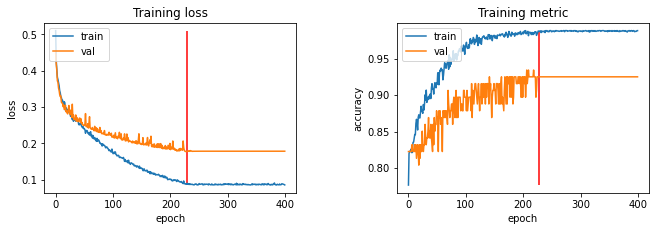

Wall time: 8h 39min 20s


In [9]:
%%time
# train model B
modelB = TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device)

optB = torch.optim.SGD(modelB.parameters(), lr=0.001)
loss_fnB = nn.CrossEntropyLoss()


epochs = 400

historyB, best_modelB, best_model_scoreB = train_save_best(model=modelB,
                                                            iterator=train_iter,
                                                            optimizer=optB,
                                                            criterion=loss_fnB,
                                                            epoch=epochs,
                                                            clip=1,
                                                            device=device)

# save model
torch.save(best_modelB, './Models/modelB')

# save history
with open('./Models/historyB.txt', 'w') as dat:
    dat.write(str(historyB))

# Model fusion

### Definitions

In [12]:
def weight_averaging(*weights):
  with torch.no_grad():
    sum = torch.zeros(weights[0].shape, device=device)
    for weight in weights:
      sum += weight
  return sum / len(weights)

In [13]:
def linear_averaging(*linears):
  """Averages several linear layers (weights + biases)"""
  with torch.no_grad():
    weights = [linear.weight for linear in linears]
    biases = [linear.bias for linear in linears]

    linear_averaged = torch.nn.Linear(linears[0].in_features, linears[0].out_features, bias=True).to(device)
    linear_averaged.weight, linear_averaged.bias = torch.nn.Parameter(weight_averaging(*weights)), torch.nn.Parameter(weight_averaging(*biases))

  return linear_averaged

In [14]:
def vanilla_fusion(modelA, modelB):
  # init
  model_fusion = TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device)

  with torch.no_grad():
    # 1) encoder
    # TODO: smarter method for embedding
    # a) embedding
    weights_A = modelA.encoder.emb.tok_emb.weight
    weights_B = modelB.encoder.emb.tok_emb.weight

    weights_fusion = weight_averaging(weights_A, weights_B) # weights seem to be exactly the same?
    model_fusion.encoder.emb.tok_emb.weight = torch.nn.Parameter(weights_fusion)

    # b) encoder layers
    for i, _ in enumerate(modelA.encoder.layers):
      # i) self-attention (fuse Q, K, V separately) # TODO: check validity of this approach
      # query
      query_A = modelA.encoder.layers[i].attention.w_q
      query_B = modelB.encoder.layers[i].attention.w_q

      query_fusion = linear_averaging(query_A, query_B)
      model_fusion.encoder.layers[i].attention.w_q = query_fusion

      # key
      key_A = modelA.encoder.layers[i].attention.w_k
      key_B = modelB.encoder.layers[i].attention.w_k

      key_fusion = linear_averaging(key_A, key_B)
      model_fusion.encoder.layers[i].attention.w_k = key_fusion

      # value
      value_A = modelA.encoder.layers[i].attention.w_v
      value_B = modelB.encoder.layers[i].attention.w_v

      value_fusion = linear_averaging(value_A, value_B)
      model_fusion.encoder.layers[i].attention.w_v = value_fusion

      # output
      output_A = modelA.encoder.layers[i].attention.w_concat
      output_B = modelB.encoder.layers[i].attention.w_concat

      output_fusion = linear_averaging(output_A, output_B)
      model_fusion.encoder.layers[i].attention.w_concat = output_fusion

      # ii) layer norm 1
      # TODO: LAYER NORM WEIGHTS ARE NOT CALLABLE???

      # iii) feed-forward network
      # layer 1
      linear_A = modelA.encoder.layers[i].ffn.linear1
      linear_B = modelB.encoder.layers[i].ffn.linear1

      linear_fusion = linear_averaging(linear_A, linear_B)
      model_fusion.encoder.layers[i].ffn.linear1 = linear_fusion

      # layer 2
      linear_A = modelA.encoder.layers[i].ffn.linear2
      linear_B = modelB.encoder.layers[i].ffn.linear2

      linear_fusion = linear_averaging(linear_A, linear_B)
      model_fusion.encoder.layers[i].ffn.linear2 = linear_fusion

      # iv) layer norm 2
      # TODO: LAYER NORM WEIGHTS ARE NOT CALLABLE???

    # 2) MLP head
    linear_A = modelA.linear
    linear_B = modelB.linear

    linear_fusion = linear_averaging(linear_A, linear_B)
    model_fusion.linear = linear_fusion

  return model_fusion

In [15]:
def test_fusion(modelA, modelB, model_fusion):
  # test fusion
  test_loss_A, test_acc_A = validation(modelA, test_iter, None, nn.CrossEntropyLoss(), device)
  test_loss_B, test_acc_B = validation(modelB, test_iter, None, nn.CrossEntropyLoss(), device)
  test_loss_fusion, test_acc_fusion = validation(model_fusion, test_iter, None, nn.CrossEntropyLoss(), device)

  # visualize
  fig, ax = plt.subplots()

  metrics_A = [test_loss_A, test_acc_A]
  metrics_B = [test_loss_B, test_acc_B]
  metrics_fusion = [test_loss_fusion, test_acc_fusion]
  metrics = ['loss', 'accuracy']
  x = np.arange(len(metrics)) # positions of bars (1 per metric)
  width = 0.25  # the width of the bars

  rects1 = ax.bar(x - width, metrics_A, width, label='model A')
  rects2 = ax.bar(x, metrics_B, width, label='model B')
  rects3 = ax.bar(x + width, metrics_fusion, width, label='model fusion')

  ax.set_ylabel('Score')
  ax.set_title('Test metrics by models')
  ax.set_xticks(x)
  ax.set_xticklabels(metrics)
  ax.legend()

  plt.show()

### (Optional) load models

In [9]:
# load parent models
# TODO: change enc_voc_size back
modelA = TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device)
modelB = TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device)

modelA.load_state_dict(torch.load('./Models/modelA'))
modelB.load_state_dict(torch.load('./Models/modelB'))

<All keys matched successfully>

### Fusion

Vanilla fusion

In [14]:
model_fusion = vanilla_fusion(modelA, modelB)

Optimal transport

In [10]:
model_fusion = TransformerClassifier(src_pad_idx = pad_idx,
                               enc_voc_size = voc_size,
                               max_len = 256,
                               d_model = 512,
                               ffn_hidden = 2048,
                               n_head = 1,
                               n_layers = 1,
                               drop_prob = 0.1,
                               device = device)

model_fusion.load_state_dict(torch.load('./Models/model_fusion_OT_pre_retraining'))

<All keys matched successfully>

### Test fusion

Randomly initialiized model for comparison

C:\Users\jjung\AppData\Local\Temp\ipykernel_12512\497957386.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu


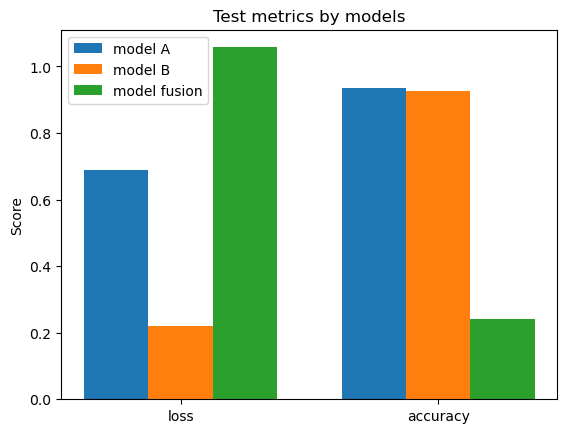

In [15]:
# test with new randomly initialized transformer
test_fusion(modelA, modelB, TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device))

Fusion model

C:\Users\jjung\AppData\Local\Temp\ipykernel_31740\497957386.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu


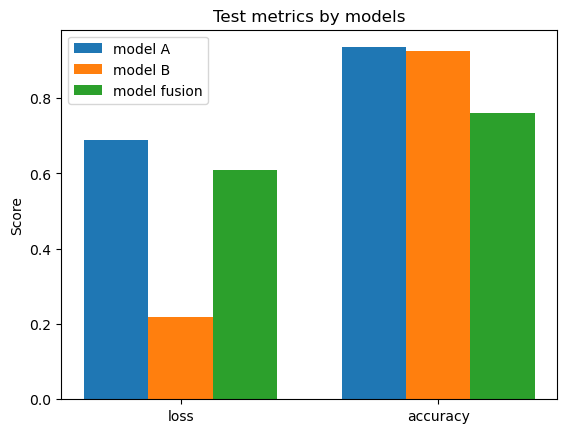

In [16]:
# test with vanilla fusion
test_fusion(modelA, modelB, model_fusion)

### Retraining

In [19]:
model_name = 'model_fusion_OT_post_retraining'

  0%|          | 0/7 [00:00<?, ?it/s]C:\Users\jjung\AppData\Local\Temp\ipykernel_31740\497957386.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
100%|██████████| 7/7 [01:08<00:00,  9.79s/it]
C:\Users\jjung\AppData\Local\Temp\ipykernel_31740\497957386.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu


Epoch: 1  Train Loss: 0.4997               Validation Loss: 0.4754               Train acc: 0.8154,               Val acc: 0.8224


100%|██████████| 7/7 [00:52<00:00,  7.54s/it]


Epoch: 2  Train Loss: 0.4546               Validation Loss: 0.4293               Train acc: 0.8216,               Val acc: 0.8224


100%|██████████| 7/7 [00:45<00:00,  6.53s/it]


Epoch: 3  Train Loss: 0.4297               Validation Loss: 0.4158               Train acc: 0.8201,               Val acc: 0.8224


100%|██████████| 7/7 [00:45<00:00,  6.52s/it]


Epoch: 4  Train Loss: 0.4013               Validation Loss: 0.3958               Train acc: 0.8191,               Val acc: 0.8131


100%|██████████| 7/7 [00:45<00:00,  6.56s/it]


Epoch: 5  Train Loss: 0.3783               Validation Loss: 0.3652               Train acc: 0.8227,               Val acc: 0.8224


100%|██████████| 7/7 [00:45<00:00,  6.53s/it]


Epoch: 6  Train Loss: 0.3727               Validation Loss: 0.3535               Train acc: 0.8212,               Val acc: 0.8224


100%|██████████| 7/7 [00:45<00:00,  6.53s/it]


Epoch: 7  Train Loss: 0.3561               Validation Loss: 0.3479               Train acc: 0.8311,               Val acc: 0.8224


100%|██████████| 7/7 [00:45<00:00,  6.47s/it]


Epoch: 8  Train Loss: 0.3614               Validation Loss: 0.3305               Train acc: 0.8219,               Val acc: 0.8224


100%|██████████| 7/7 [00:45<00:00,  6.50s/it]


Epoch: 9  Train Loss: 0.3380               Validation Loss: 0.3224               Train acc: 0.8383,               Val acc: 0.8224


100%|██████████| 7/7 [00:45<00:00,  6.52s/it]


Epoch: 10  Train Loss: 0.3356               Validation Loss: 0.3239               Train acc: 0.8262,               Val acc: 0.8318


100%|██████████| 7/7 [00:45<00:00,  6.53s/it]


Epoch: 11  Train Loss: 0.3235               Validation Loss: 0.3263               Train acc: 0.8544,               Val acc: 0.8224


100%|██████████| 7/7 [00:45<00:00,  6.52s/it]


Epoch: 12  Train Loss: 0.3221               Validation Loss: 0.3073               Train acc: 0.8547,               Val acc: 0.8224


100%|██████████| 7/7 [00:45<00:00,  6.50s/it]


Epoch: 13  Train Loss: 0.3152               Validation Loss: 0.3037               Train acc: 0.8598,               Val acc: 0.8131


100%|██████████| 7/7 [00:45<00:00,  6.55s/it]


Epoch: 14  Train Loss: 0.3096               Validation Loss: 0.3032               Train acc: 0.8606,               Val acc: 0.8505


100%|██████████| 7/7 [00:46<00:00,  6.65s/it]


Epoch: 15  Train Loss: 0.3085               Validation Loss: 0.2945               Train acc: 0.8677,               Val acc: 0.8131


100%|██████████| 7/7 [00:45<00:00,  6.48s/it]


Epoch: 16  Train Loss: 0.3058               Validation Loss: 0.3059               Train acc: 0.8620,               Val acc: 0.8224


100%|██████████| 7/7 [00:45<00:00,  6.47s/it]


Epoch: 17  Train Loss: 0.3071               Validation Loss: 0.2917               Train acc: 0.8621,               Val acc: 0.8131


100%|██████████| 7/7 [00:45<00:00,  6.46s/it]


Epoch: 18  Train Loss: 0.3049               Validation Loss: 0.3026               Train acc: 0.8574,               Val acc: 0.8411


100%|██████████| 7/7 [00:45<00:00,  6.43s/it]


Epoch: 19  Train Loss: 0.2990               Validation Loss: 0.2871               Train acc: 0.8590,               Val acc: 0.8037


100%|██████████| 7/7 [00:46<00:00,  6.67s/it]


Epoch: 20  Train Loss: 0.2936               Validation Loss: 0.2927               Train acc: 0.8680,               Val acc: 0.8224


100%|██████████| 7/7 [00:52<00:00,  7.51s/it]


Epoch: 21  Train Loss: 0.2954               Validation Loss: 0.2844               Train acc: 0.8682,               Val acc: 0.8505


100%|██████████| 7/7 [00:51<00:00,  7.31s/it]


Epoch: 22  Train Loss: 0.2941               Validation Loss: 0.2830               Train acc: 0.8757,               Val acc: 0.8505


100%|██████████| 7/7 [00:50<00:00,  7.28s/it]


Epoch: 23  Train Loss: 0.2867               Validation Loss: 0.2930               Train acc: 0.8860,               Val acc: 0.8224


100%|██████████| 7/7 [00:51<00:00,  7.31s/it]


Epoch: 24  Train Loss: 0.2841               Validation Loss: 0.2945               Train acc: 0.8888,               Val acc: 0.8411


100%|██████████| 7/7 [00:51<00:00,  7.29s/it]


Epoch: 25  Train Loss: 0.2898               Validation Loss: 0.2774               Train acc: 0.8723,               Val acc: 0.8505


100%|██████████| 7/7 [00:50<00:00,  7.27s/it]


Epoch: 26  Train Loss: 0.2778               Validation Loss: 0.2864               Train acc: 0.8824,               Val acc: 0.8224


100%|██████████| 7/7 [00:51<00:00,  7.29s/it]


Epoch: 27  Train Loss: 0.2831               Validation Loss: 0.2774               Train acc: 0.8813,               Val acc: 0.8598


100%|██████████| 7/7 [00:50<00:00,  7.29s/it]


Epoch: 28  Train Loss: 0.2853               Validation Loss: 0.2843               Train acc: 0.8837,               Val acc: 0.8318


100%|██████████| 7/7 [00:51<00:00,  7.29s/it]


Epoch: 29  Train Loss: 0.2729               Validation Loss: 0.2939               Train acc: 0.8920,               Val acc: 0.8224


100%|██████████| 7/7 [00:50<00:00,  7.27s/it]


Epoch: 30  Train Loss: 0.2760               Validation Loss: 0.2715               Train acc: 0.8874,               Val acc: 0.8131


100%|██████████| 7/7 [00:50<00:00,  7.27s/it]


Epoch: 31  Train Loss: 0.2764               Validation Loss: 0.2880               Train acc: 0.9026,               Val acc: 0.8224


100%|██████████| 7/7 [00:50<00:00,  7.27s/it]


Epoch: 32  Train Loss: 0.2736               Validation Loss: 0.2808               Train acc: 0.9004,               Val acc: 0.8224


100%|██████████| 7/7 [00:50<00:00,  7.28s/it]


Epoch: 33  Train Loss: 0.2640               Validation Loss: 0.2727               Train acc: 0.8938,               Val acc: 0.8411


100%|██████████| 7/7 [00:50<00:00,  7.25s/it]


Epoch: 34  Train Loss: 0.2634               Validation Loss: 0.2668               Train acc: 0.9020,               Val acc: 0.8411


100%|██████████| 7/7 [00:51<00:00,  7.31s/it]


Epoch: 35  Train Loss: 0.2628               Validation Loss: 0.2666               Train acc: 0.9145,               Val acc: 0.8224


100%|██████████| 7/7 [00:50<00:00,  7.26s/it]


Epoch: 36  Train Loss: 0.2692               Validation Loss: 0.2659               Train acc: 0.8970,               Val acc: 0.8692


100%|██████████| 7/7 [00:51<00:00,  7.29s/it]


Epoch: 37  Train Loss: 0.2642               Validation Loss: 0.2676               Train acc: 0.9060,               Val acc: 0.8505


100%|██████████| 7/7 [00:51<00:00,  7.29s/it]


Epoch: 38  Train Loss: 0.2635               Validation Loss: 0.2639               Train acc: 0.9127,               Val acc: 0.8598


100%|██████████| 7/7 [00:50<00:00,  7.26s/it]


Epoch: 39  Train Loss: 0.2553               Validation Loss: 0.2743               Train acc: 0.9131,               Val acc: 0.8692


100%|██████████| 7/7 [00:50<00:00,  7.26s/it]


Epoch: 40  Train Loss: 0.2593               Validation Loss: 0.2633               Train acc: 0.9165,               Val acc: 0.8411


100%|██████████| 7/7 [00:50<00:00,  7.25s/it]


Epoch: 41  Train Loss: 0.2534               Validation Loss: 0.2598               Train acc: 0.9128,               Val acc: 0.8505


100%|██████████| 7/7 [00:50<00:00,  7.28s/it]


Epoch: 42  Train Loss: 0.2536               Validation Loss: 0.2584               Train acc: 0.9157,               Val acc: 0.8598


100%|██████████| 7/7 [00:50<00:00,  7.28s/it]


Epoch: 43  Train Loss: 0.2538               Validation Loss: 0.2609               Train acc: 0.9140,               Val acc: 0.8692


100%|██████████| 7/7 [00:50<00:00,  7.28s/it]


Epoch: 44  Train Loss: 0.2529               Validation Loss: 0.2591               Train acc: 0.9156,               Val acc: 0.8692


100%|██████████| 7/7 [00:50<00:00,  7.25s/it]


Epoch: 45  Train Loss: 0.2453               Validation Loss: 0.2559               Train acc: 0.9200,               Val acc: 0.8692


100%|██████████| 7/7 [00:50<00:00,  7.27s/it]


Epoch: 46  Train Loss: 0.2437               Validation Loss: 0.2556               Train acc: 0.9301,               Val acc: 0.8692


100%|██████████| 7/7 [00:50<00:00,  7.26s/it]


Epoch: 47  Train Loss: 0.2429               Validation Loss: 0.2618               Train acc: 0.9217,               Val acc: 0.8505


100%|██████████| 7/7 [00:50<00:00,  7.28s/it]


Epoch: 48  Train Loss: 0.2397               Validation Loss: 0.2522               Train acc: 0.9295,               Val acc: 0.8692


100%|██████████| 7/7 [00:50<00:00,  7.27s/it]


Epoch: 49  Train Loss: 0.2415               Validation Loss: 0.2516               Train acc: 0.9269,               Val acc: 0.8692


100%|██████████| 7/7 [00:51<00:00,  7.29s/it]


Epoch: 50  Train Loss: 0.2354               Validation Loss: 0.2564               Train acc: 0.9315,               Val acc: 0.8692


100%|██████████| 7/7 [00:50<00:00,  7.26s/it]


Epoch: 51  Train Loss: 0.2434               Validation Loss: 0.2501               Train acc: 0.9193,               Val acc: 0.8598


100%|██████████| 7/7 [00:51<00:00,  7.29s/it]


Epoch: 52  Train Loss: 0.2352               Validation Loss: 0.2520               Train acc: 0.9351,               Val acc: 0.8785


100%|██████████| 7/7 [00:50<00:00,  7.27s/it]


Epoch: 53  Train Loss: 0.2425               Validation Loss: 0.2488               Train acc: 0.9150,               Val acc: 0.8598


100%|██████████| 7/7 [00:50<00:00,  7.27s/it]


Epoch: 54  Train Loss: 0.2328               Validation Loss: 0.2588               Train acc: 0.9274,               Val acc: 0.8692


100%|██████████| 7/7 [00:50<00:00,  7.27s/it]


Epoch: 55  Train Loss: 0.2313               Validation Loss: 0.2472               Train acc: 0.9323,               Val acc: 0.8598


100%|██████████| 7/7 [00:50<00:00,  7.24s/it]


Epoch: 56  Train Loss: 0.2277               Validation Loss: 0.2460               Train acc: 0.9378,               Val acc: 0.8785


100%|██████████| 7/7 [00:50<00:00,  7.27s/it]


Epoch: 57  Train Loss: 0.2257               Validation Loss: 0.2581               Train acc: 0.9372,               Val acc: 0.8692


100%|██████████| 7/7 [00:51<00:00,  7.30s/it]


Epoch: 58  Train Loss: 0.2332               Validation Loss: 0.2446               Train acc: 0.9240,               Val acc: 0.8879


100%|██████████| 7/7 [00:50<00:00,  7.26s/it]


Epoch: 59  Train Loss: 0.2264               Validation Loss: 0.2451               Train acc: 0.9238,               Val acc: 0.8692


100%|██████████| 7/7 [00:50<00:00,  7.27s/it]


Epoch: 60  Train Loss: 0.2215               Validation Loss: 0.2443               Train acc: 0.9385,               Val acc: 0.8785


100%|██████████| 7/7 [00:50<00:00,  7.28s/it]


Epoch: 61  Train Loss: 0.2209               Validation Loss: 0.2426               Train acc: 0.9395,               Val acc: 0.8879


100%|██████████| 7/7 [00:51<00:00,  7.29s/it]


Epoch: 62  Train Loss: 0.2175               Validation Loss: 0.2462               Train acc: 0.9477,               Val acc: 0.8692


100%|██████████| 7/7 [00:50<00:00,  7.25s/it]


Epoch: 63  Train Loss: 0.2198               Validation Loss: 0.2428               Train acc: 0.9389,               Val acc: 0.8692


100%|██████████| 7/7 [00:50<00:00,  7.28s/it]


Epoch: 64  Train Loss: 0.2180               Validation Loss: 0.2402               Train acc: 0.9455,               Val acc: 0.8785


100%|██████████| 7/7 [00:50<00:00,  7.27s/it]


Epoch: 65  Train Loss: 0.2135               Validation Loss: 0.2390               Train acc: 0.9390,               Val acc: 0.9065


100%|██████████| 7/7 [00:50<00:00,  7.28s/it]


Epoch: 66  Train Loss: 0.2177               Validation Loss: 0.2492               Train acc: 0.9414,               Val acc: 0.8692


100%|██████████| 7/7 [00:51<00:00,  7.31s/it]


Epoch: 67  Train Loss: 0.2107               Validation Loss: 0.2380               Train acc: 0.9466,               Val acc: 0.9065


100%|██████████| 7/7 [00:50<00:00,  7.28s/it]


Epoch: 68  Train Loss: 0.2103               Validation Loss: 0.2452               Train acc: 0.9417,               Val acc: 0.8598


100%|██████████| 7/7 [00:50<00:00,  7.25s/it]


Epoch: 69  Train Loss: 0.2082               Validation Loss: 0.2504               Train acc: 0.9432,               Val acc: 0.8785


100%|██████████| 7/7 [00:50<00:00,  7.27s/it]


Epoch: 70  Train Loss: 0.2131               Validation Loss: 0.2365               Train acc: 0.9511,               Val acc: 0.9065


100%|██████████| 7/7 [00:50<00:00,  7.29s/it]


Epoch: 71  Train Loss: 0.2051               Validation Loss: 0.2511               Train acc: 0.9510,               Val acc: 0.8411


100%|██████████| 7/7 [00:51<00:00,  7.30s/it]


Epoch: 72  Train Loss: 0.2097               Validation Loss: 0.2359               Train acc: 0.9395,               Val acc: 0.8972


100%|██████████| 7/7 [00:50<00:00,  7.27s/it]


Epoch: 73  Train Loss: 0.2032               Validation Loss: 0.2462               Train acc: 0.9454,               Val acc: 0.8411


100%|██████████| 7/7 [00:51<00:00,  7.29s/it]


Epoch: 74  Train Loss: 0.2042               Validation Loss: 0.2353               Train acc: 0.9493,               Val acc: 0.8879


100%|██████████| 7/7 [00:51<00:00,  7.30s/it]


Epoch: 75  Train Loss: 0.2071               Validation Loss: 0.2482               Train acc: 0.9485,               Val acc: 0.8785


100%|██████████| 7/7 [00:51<00:00,  7.30s/it]


Epoch: 76  Train Loss: 0.1973               Validation Loss: 0.2365               Train acc: 0.9532,               Val acc: 0.8692


100%|██████████| 7/7 [00:50<00:00,  7.26s/it]


Epoch: 77  Train Loss: 0.1937               Validation Loss: 0.2541               Train acc: 0.9649,               Val acc: 0.8411


100%|██████████| 7/7 [00:51<00:00,  7.29s/it]


Epoch: 78  Train Loss: 0.2027               Validation Loss: 0.2327               Train acc: 0.9338,               Val acc: 0.8879


100%|██████████| 7/7 [00:51<00:00,  7.30s/it]


Epoch: 79  Train Loss: 0.1962               Validation Loss: 0.2548               Train acc: 0.9538,               Val acc: 0.8785


100%|██████████| 7/7 [00:51<00:00,  7.30s/it]


Epoch: 80  Train Loss: 0.1970               Validation Loss: 0.2309               Train acc: 0.9552,               Val acc: 0.8879


100%|██████████| 7/7 [00:50<00:00,  7.28s/it]


Epoch: 81  Train Loss: 0.1908               Validation Loss: 0.2307               Train acc: 0.9589,               Val acc: 0.8785


100%|██████████| 7/7 [00:51<00:00,  7.30s/it]


Epoch: 82  Train Loss: 0.1901               Validation Loss: 0.2363               Train acc: 0.9532,               Val acc: 0.8785


100%|██████████| 7/7 [00:50<00:00,  7.28s/it]


Epoch: 83  Train Loss: 0.1904               Validation Loss: 0.2288               Train acc: 0.9621,               Val acc: 0.8972


100%|██████████| 7/7 [00:50<00:00,  7.28s/it]


Epoch: 84  Train Loss: 0.1915               Validation Loss: 0.2329               Train acc: 0.9638,               Val acc: 0.8692


100%|██████████| 7/7 [00:50<00:00,  7.28s/it]


Epoch: 85  Train Loss: 0.1886               Validation Loss: 0.2456               Train acc: 0.9640,               Val acc: 0.8879


100%|██████████| 7/7 [00:51<00:00,  7.32s/it]


Epoch: 86  Train Loss: 0.1884               Validation Loss: 0.2288               Train acc: 0.9568,               Val acc: 0.8785


100%|██████████| 7/7 [00:49<00:00,  7.03s/it]


Epoch: 87  Train Loss: 0.1881               Validation Loss: 0.2325               Train acc: 0.9649,               Val acc: 0.8598


100%|██████████| 7/7 [00:45<00:00,  6.52s/it]


Epoch: 88  Train Loss: 0.1835               Validation Loss: 0.2298               Train acc: 0.9621,               Val acc: 0.8879


100%|██████████| 7/7 [00:45<00:00,  6.52s/it]


Epoch: 89  Train Loss: 0.1852               Validation Loss: 0.2361               Train acc: 0.9652,               Val acc: 0.8785


100%|██████████| 7/7 [00:45<00:00,  6.53s/it]


Epoch: 90  Train Loss: 0.1800               Validation Loss: 0.2312               Train acc: 0.9645,               Val acc: 0.8785


100%|██████████| 7/7 [00:45<00:00,  6.55s/it]


Epoch: 91  Train Loss: 0.1787               Validation Loss: 0.2276               Train acc: 0.9677,               Val acc: 0.8785


100%|██████████| 7/7 [00:45<00:00,  6.52s/it]


Epoch: 92  Train Loss: 0.1788               Validation Loss: 0.2233               Train acc: 0.9683,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.56s/it]


Epoch: 93  Train Loss: 0.1770               Validation Loss: 0.2239               Train acc: 0.9662,               Val acc: 0.8879


100%|██████████| 7/7 [00:45<00:00,  6.53s/it]


Epoch: 94  Train Loss: 0.1765               Validation Loss: 0.2320               Train acc: 0.9666,               Val acc: 0.8879


100%|██████████| 7/7 [00:45<00:00,  6.54s/it]


Epoch: 95  Train Loss: 0.1755               Validation Loss: 0.2235               Train acc: 0.9727,               Val acc: 0.8879


100%|██████████| 7/7 [00:45<00:00,  6.55s/it]


Epoch: 96  Train Loss: 0.1745               Validation Loss: 0.2224               Train acc: 0.9683,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.56s/it]


Epoch: 97  Train Loss: 0.1741               Validation Loss: 0.2218               Train acc: 0.9655,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.56s/it]


Epoch: 98  Train Loss: 0.1723               Validation Loss: 0.2206               Train acc: 0.9640,               Val acc: 0.9065


100%|██████████| 7/7 [00:46<00:00,  6.60s/it]


Epoch: 99  Train Loss: 0.1703               Validation Loss: 0.2197               Train acc: 0.9694,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.50s/it]


Epoch: 100  Train Loss: 0.1658               Validation Loss: 0.2196               Train acc: 0.9699,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.50s/it]


Epoch: 101  Train Loss: 0.1705               Validation Loss: 0.2310               Train acc: 0.9610,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.50s/it]


Epoch: 102  Train Loss: 0.1687               Validation Loss: 0.2426               Train acc: 0.9700,               Val acc: 0.8879


100%|██████████| 7/7 [00:45<00:00,  6.49s/it]


Epoch: 103  Train Loss: 0.1686               Validation Loss: 0.2333               Train acc: 0.9634,               Val acc: 0.8879


100%|██████████| 7/7 [00:45<00:00,  6.50s/it]


Epoch: 104  Train Loss: 0.1701               Validation Loss: 0.2236               Train acc: 0.9734,               Val acc: 0.8785


100%|██████████| 7/7 [00:45<00:00,  6.49s/it]


Epoch: 105  Train Loss: 0.1613               Validation Loss: 0.2233               Train acc: 0.9695,               Val acc: 0.8785


100%|██████████| 7/7 [00:45<00:00,  6.49s/it]


Epoch: 106  Train Loss: 0.1567               Validation Loss: 0.2185               Train acc: 0.9754,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.51s/it]


Epoch: 107  Train Loss: 0.1590               Validation Loss: 0.2191               Train acc: 0.9733,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.51s/it]


Epoch: 108  Train Loss: 0.1591               Validation Loss: 0.2230               Train acc: 0.9716,               Val acc: 0.8785


100%|██████████| 7/7 [00:45<00:00,  6.50s/it]


Epoch: 109  Train Loss: 0.1558               Validation Loss: 0.2166               Train acc: 0.9733,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.49s/it]


Epoch: 110  Train Loss: 0.1578               Validation Loss: 0.2200               Train acc: 0.9723,               Val acc: 0.8785


100%|██████████| 7/7 [00:45<00:00,  6.48s/it]


Epoch: 111  Train Loss: 0.1601               Validation Loss: 0.2150               Train acc: 0.9745,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.47s/it]


Epoch: 112  Train Loss: 0.1553               Validation Loss: 0.2296               Train acc: 0.9733,               Val acc: 0.8598


100%|██████████| 7/7 [00:45<00:00,  6.49s/it]


Epoch: 113  Train Loss: 0.1579               Validation Loss: 0.2156               Train acc: 0.9717,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.47s/it]


Epoch: 114  Train Loss: 0.1541               Validation Loss: 0.2202               Train acc: 0.9800,               Val acc: 0.8879


100%|██████████| 7/7 [00:45<00:00,  6.51s/it]


Epoch: 115  Train Loss: 0.1569               Validation Loss: 0.2114               Train acc: 0.9755,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.51s/it]


Epoch: 116  Train Loss: 0.1548               Validation Loss: 0.2160               Train acc: 0.9762,               Val acc: 0.8785


100%|██████████| 7/7 [00:45<00:00,  6.45s/it]


Epoch: 117  Train Loss: 0.1512               Validation Loss: 0.2189               Train acc: 0.9778,               Val acc: 0.8879


100%|██████████| 7/7 [00:45<00:00,  6.49s/it]


Epoch: 118  Train Loss: 0.1485               Validation Loss: 0.2135               Train acc: 0.9710,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.47s/it]


Epoch: 119  Train Loss: 0.1482               Validation Loss: 0.2144               Train acc: 0.9738,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.52s/it]


Epoch: 120  Train Loss: 0.1450               Validation Loss: 0.2128               Train acc: 0.9772,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.51s/it]


Epoch: 121  Train Loss: 0.1508               Validation Loss: 0.2101               Train acc: 0.9767,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.53s/it]


Epoch: 122  Train Loss: 0.1434               Validation Loss: 0.2184               Train acc: 0.9766,               Val acc: 0.8879


100%|██████████| 7/7 [00:45<00:00,  6.50s/it]


Epoch: 123  Train Loss: 0.1462               Validation Loss: 0.2111               Train acc: 0.9766,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.50s/it]


Epoch: 124  Train Loss: 0.1434               Validation Loss: 0.2125               Train acc: 0.9733,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.47s/it]


Epoch: 125  Train Loss: 0.1460               Validation Loss: 0.2088               Train acc: 0.9811,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.48s/it]


Epoch: 126  Train Loss: 0.1465               Validation Loss: 0.2076               Train acc: 0.9774,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.51s/it]


Epoch: 127  Train Loss: 0.1421               Validation Loss: 0.2143               Train acc: 0.9805,               Val acc: 0.8879


100%|██████████| 7/7 [00:45<00:00,  6.54s/it]


Epoch: 128  Train Loss: 0.1384               Validation Loss: 0.2088               Train acc: 0.9783,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.48s/it]


Epoch: 129  Train Loss: 0.1373               Validation Loss: 0.2087               Train acc: 0.9783,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.47s/it]


Epoch: 130  Train Loss: 0.1371               Validation Loss: 0.2063               Train acc: 0.9783,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.50s/it]


Epoch: 131  Train Loss: 0.1388               Validation Loss: 0.2075               Train acc: 0.9774,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.50s/it]


Epoch: 132  Train Loss: 0.1349               Validation Loss: 0.2054               Train acc: 0.9788,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.50s/it]


Epoch: 133  Train Loss: 0.1376               Validation Loss: 0.2082               Train acc: 0.9779,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.49s/it]


Epoch: 134  Train Loss: 0.1393               Validation Loss: 0.2102               Train acc: 0.9812,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.50s/it]


Epoch: 135  Train Loss: 0.1354               Validation Loss: 0.2050               Train acc: 0.9844,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.48s/it]


Epoch: 136  Train Loss: 0.1361               Validation Loss: 0.2056               Train acc: 0.9754,               Val acc: 0.9159


100%|██████████| 7/7 [00:45<00:00,  6.49s/it]


Epoch: 137  Train Loss: 0.1297               Validation Loss: 0.2050               Train acc: 0.9794,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.53s/it]


Epoch: 138  Train Loss: 0.1354               Validation Loss: 0.2041               Train acc: 0.9784,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.47s/it]


Epoch: 139  Train Loss: 0.1293               Validation Loss: 0.2056               Train acc: 0.9833,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.50s/it]


Epoch: 140  Train Loss: 0.1297               Validation Loss: 0.2097               Train acc: 0.9794,               Val acc: 0.8879


100%|██████████| 7/7 [00:45<00:00,  6.50s/it]


Epoch: 141  Train Loss: 0.1357               Validation Loss: 0.2139               Train acc: 0.9790,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.46s/it]


Epoch: 142  Train Loss: 0.1334               Validation Loss: 0.2041               Train acc: 0.9795,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.53s/it]


Epoch: 143  Train Loss: 0.1322               Validation Loss: 0.2233               Train acc: 0.9789,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.46s/it]


Epoch: 144  Train Loss: 0.1332               Validation Loss: 0.2033               Train acc: 0.9828,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.50s/it]


Epoch: 145  Train Loss: 0.1282               Validation Loss: 0.2025               Train acc: 0.9821,               Val acc: 0.9065


100%|██████████| 7/7 [00:47<00:00,  6.73s/it]


Epoch: 146  Train Loss: 0.1260               Validation Loss: 0.1996               Train acc: 0.9794,               Val acc: 0.9065


100%|██████████| 7/7 [00:46<00:00,  6.62s/it]


Epoch: 147  Train Loss: 0.1256               Validation Loss: 0.1991               Train acc: 0.9794,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.57s/it]


Epoch: 148  Train Loss: 0.1271               Validation Loss: 0.2038               Train acc: 0.9839,               Val acc: 0.9065


100%|██████████| 7/7 [00:46<00:00,  6.57s/it]


Epoch: 149  Train Loss: 0.1265               Validation Loss: 0.1993               Train acc: 0.9811,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.53s/it]


Epoch: 150  Train Loss: 0.1220               Validation Loss: 0.2095               Train acc: 0.9828,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.56s/it]


Epoch: 151  Train Loss: 0.1273               Validation Loss: 0.1978               Train acc: 0.9783,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.54s/it]


Epoch: 152  Train Loss: 0.1244               Validation Loss: 0.1982               Train acc: 0.9788,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.54s/it]


Epoch: 153  Train Loss: 0.1227               Validation Loss: 0.1972               Train acc: 0.9795,               Val acc: 0.9065


100%|██████████| 7/7 [00:46<00:00,  6.58s/it]


Epoch: 154  Train Loss: 0.1218               Validation Loss: 0.2033               Train acc: 0.9845,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.54s/it]


Epoch: 155  Train Loss: 0.1198               Validation Loss: 0.2106               Train acc: 0.9861,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.55s/it]


Epoch: 156  Train Loss: 0.1218               Validation Loss: 0.1981               Train acc: 0.9789,               Val acc: 0.9065


100%|██████████| 7/7 [00:46<00:00,  6.58s/it]


Epoch: 157  Train Loss: 0.1184               Validation Loss: 0.2008               Train acc: 0.9810,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.55s/it]


Epoch: 158  Train Loss: 0.1279               Validation Loss: 0.1968               Train acc: 0.9768,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.54s/it]


Epoch: 159  Train Loss: 0.1202               Validation Loss: 0.2007               Train acc: 0.9816,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.53s/it]


Epoch: 160  Train Loss: 0.1213               Validation Loss: 0.1956               Train acc: 0.9806,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.55s/it]


Epoch: 161  Train Loss: 0.1190               Validation Loss: 0.1961               Train acc: 0.9839,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.53s/it]


Epoch: 162  Train Loss: 0.1179               Validation Loss: 0.1959               Train acc: 0.9811,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.51s/it]


Epoch: 163  Train Loss: 0.1129               Validation Loss: 0.1974               Train acc: 0.9855,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.50s/it]


Epoch: 164  Train Loss: 0.1162               Validation Loss: 0.1976               Train acc: 0.9828,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.52s/it]


Epoch: 165  Train Loss: 0.1121               Validation Loss: 0.1947               Train acc: 0.9833,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.52s/it]


Epoch: 166  Train Loss: 0.1157               Validation Loss: 0.1956               Train acc: 0.9817,               Val acc: 0.9159


100%|██████████| 7/7 [00:45<00:00,  6.52s/it]


Epoch: 167  Train Loss: 0.1127               Validation Loss: 0.1930               Train acc: 0.9828,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.51s/it]


Epoch: 168  Train Loss: 0.1166               Validation Loss: 0.1969               Train acc: 0.9851,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.50s/it]


Epoch: 169  Train Loss: 0.1107               Validation Loss: 0.1990               Train acc: 0.9872,               Val acc: 0.9065


100%|██████████| 7/7 [00:46<00:00,  6.61s/it]


Epoch: 170  Train Loss: 0.1114               Validation Loss: 0.1973               Train acc: 0.9866,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.50s/it]


Epoch: 171  Train Loss: 0.1082               Validation Loss: 0.2023               Train acc: 0.9856,               Val acc: 0.8879


100%|██████████| 7/7 [00:45<00:00,  6.53s/it]


Epoch: 172  Train Loss: 0.1131               Validation Loss: 0.1918               Train acc: 0.9811,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.54s/it]


Epoch: 173  Train Loss: 0.1097               Validation Loss: 0.1917               Train acc: 0.9833,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.49s/it]


Epoch: 174  Train Loss: 0.1145               Validation Loss: 0.1945               Train acc: 0.9795,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.47s/it]


Epoch: 175  Train Loss: 0.1111               Validation Loss: 0.1943               Train acc: 0.9811,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.57s/it]


Epoch: 176  Train Loss: 0.1090               Validation Loss: 0.1911               Train acc: 0.9866,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.50s/it]


Epoch: 177  Train Loss: 0.1085               Validation Loss: 0.1907               Train acc: 0.9877,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.50s/it]


Epoch: 178  Train Loss: 0.1053               Validation Loss: 0.1961               Train acc: 0.9844,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.49s/it]


Epoch: 179  Train Loss: 0.1063               Validation Loss: 0.1914               Train acc: 0.9834,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.55s/it]


Epoch: 180  Train Loss: 0.1072               Validation Loss: 0.1897               Train acc: 0.9845,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.48s/it]


Epoch: 181  Train Loss: 0.1046               Validation Loss: 0.1971               Train acc: 0.9888,               Val acc: 0.9252


100%|██████████| 7/7 [00:45<00:00,  6.54s/it]


Epoch: 182  Train Loss: 0.1012               Validation Loss: 0.1917               Train acc: 0.9845,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.50s/it]


Epoch: 183  Train Loss: 0.1107               Validation Loss: 0.1882               Train acc: 0.9852,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.49s/it]


Epoch: 184  Train Loss: 0.1041               Validation Loss: 0.1939               Train acc: 0.9888,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.52s/it]


Epoch: 185  Train Loss: 0.1001               Validation Loss: 0.1891               Train acc: 0.9855,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.53s/it]


Epoch: 186  Train Loss: 0.1035               Validation Loss: 0.1879               Train acc: 0.9856,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.54s/it]


Epoch: 187  Train Loss: 0.1015               Validation Loss: 0.1881               Train acc: 0.9850,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.49s/it]


Epoch: 188  Train Loss: 0.0995               Validation Loss: 0.1878               Train acc: 0.9883,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.51s/it]


Epoch: 189  Train Loss: 0.1010               Validation Loss: 0.1912               Train acc: 0.9894,               Val acc: 0.9159


100%|██████████| 7/7 [00:45<00:00,  6.55s/it]


Epoch: 190  Train Loss: 0.0975               Validation Loss: 0.1882               Train acc: 0.9900,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.54s/it]


Epoch: 191  Train Loss: 0.0986               Validation Loss: 0.1898               Train acc: 0.9861,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.50s/it]


Epoch: 192  Train Loss: 0.0969               Validation Loss: 0.2011               Train acc: 0.9861,               Val acc: 0.9346


100%|██████████| 7/7 [00:45<00:00,  6.55s/it]


Epoch: 193  Train Loss: 0.1025               Validation Loss: 0.1870               Train acc: 0.9857,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.53s/it]


Epoch: 194  Train Loss: 0.0941               Validation Loss: 0.1864               Train acc: 0.9872,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.55s/it]


Epoch: 195  Train Loss: 0.0966               Validation Loss: 0.1892               Train acc: 0.9878,               Val acc: 0.9159


100%|██████████| 7/7 [00:45<00:00,  6.54s/it]


Epoch: 196  Train Loss: 0.0971               Validation Loss: 0.1859               Train acc: 0.9867,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.51s/it]


Epoch: 197  Train Loss: 0.0968               Validation Loss: 0.1874               Train acc: 0.9846,               Val acc: 0.9065


100%|██████████| 7/7 [00:45<00:00,  6.51s/it]


Epoch: 198  Train Loss: 0.0937               Validation Loss: 0.1861               Train acc: 0.9861,               Val acc: 0.8972


100%|██████████| 7/7 [00:45<00:00,  6.53s/it]


Epoch: 199  Train Loss: 0.0950               Validation Loss: 0.1936               Train acc: 0.9878,               Val acc: 0.9346


100%|██████████| 7/7 [00:45<00:00,  6.53s/it]


Epoch: 200  Train Loss: 0.0934               Validation Loss: 0.1862               Train acc: 0.9894,               Val acc: 0.9065


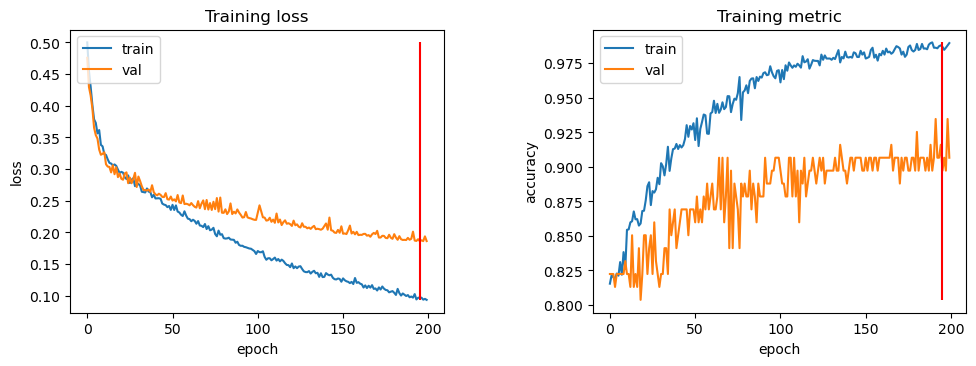

CPU times: total: 16h 27min 25s
Wall time: 2h 45min 12s


In [17]:
%%time
opt_fusion = torch.optim.SGD(model_fusion.parameters(), lr=0.001)
loss_fn_fusion = nn.CrossEntropyLoss()


epochs = 200
history_fusion, best_model_fusion, best_model_score_fusion = train_save_best(model=model_fusion,
                                                                             iterator=train_iter,
                                                                             optimizer=opt_fusion,
                                                                             criterion=loss_fn_fusion,
                                                                             epoch=epochs,
                                                                             clip=1,
                                                                             device=device)

In [20]:
# save model
torch.save(best_model_fusion, f'./Models/{model_name}')

# save history
with open(f'./Models/history_{model_name}.txt', 'w') as dat:
    dat.write(str(history_fusion))

In [21]:
# load best model (current model is trained on full epochs)
model_fusion.load_state_dict(best_model_fusion)

<All keys matched successfully>

### Test fusion (after retraining)

C:\Users\jjung\AppData\Local\Temp\ipykernel_31740\497957386.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu


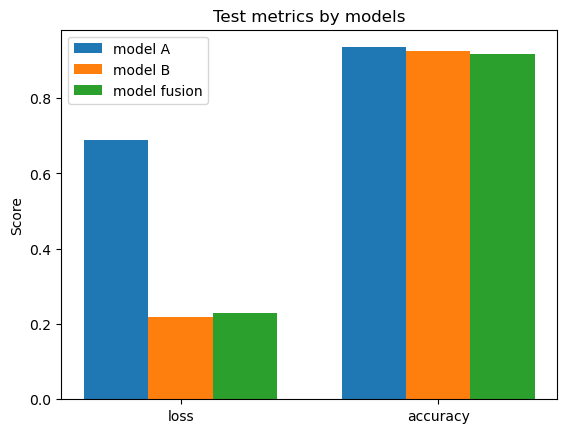

In [22]:
# test with vanilla fusion
test_fusion(modelA, modelB, model_fusion)